# **TOXIC COMMENT CLASSIFICATION**

This project has been developed by my collegues and I on a dataset of toxic comments. Our task was to perform a multi-label classification analysis on about 200'000 comments in order to identify which of them were to be considered as "toxic", "severe toxic", "obscene", "insult", "threat" and/or "identity hate" (6 possible classes of toxicity).

The project essentially consists in 5 steps:
*   *Data preparation and cleaning*:
    - manipulation of the dataset and in particular of the comments in order to build and select the relevant columns, check for missing values or empty strings;
* *Exploratory analysis*:
    - analysis of the distribution and the frequency of the labels, length of the sentences, most frequent words, stopwords and relationship among the different classes of toxicity;
    - analysis of Part of Speech (PoS) tagging and Named Entity Recognition (NER);
*   *Neural Network approach*:
    - creation and evaluation of a LSTM neural network, focusing on the different evaluation metrics available and trying to improve the performance with an alternative model;
*   *Transformer Based Approach*: 
    - implementation and performance evaluation of a pretrained model;
*   *Comparison of LSTM and BERT*:
    - final comparison of the results obtained through the two deep learning models.

The dataset is available at this [link](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data).

## Preliminary operations


**Load Libraries**

We import all the libraries needed.

In [5]:
import pandas as pd
import re
from statistics import mode
import spacy
from wordcloud import WordCloud
from spacy import displacy
import itertools, collections
from collections import Counter
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import string
import warnings
warnings.filterwarnings("ignore")

## Importing the dataset

The _**train_df**_ variable already embodies both the text comments and their respective labels. For the test set, we have comments and labels in distinct files so we import them into distinct variables (_**test_com**_ and _**test_lables**_) and then we will match and join them together.



In [6]:
train_df = pd.read_csv('train.csv')
test_com = pd.read_csv('test.csv')
test_labels = pd.read_csv('test_labels.csv')

Now we look at the head of our dataset. We decided to extend the head overview until the 30<sup>th</sup> instance to have a better understanding of the dataset.

In [4]:
train_df.head(31)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,249153143547788,No need to follow this Policy Taivo instead of...,0,0,0,0,0,0
1,370084287833724,"""\n\nIs this person cuchullian a member of the...",0,0,0,0,0,0
2,463311984751990,"""\n\nWhilst I don't agree with your reasoning,...",0,0,0,0,0,0
3,555281658565433,"December 2008 (UTC)\n\nWell said, I had exactl...",0,0,0,0,0,0
4,677031090441076,"""Awesome, thanks for taking the time to do so,...",0,0,0,0,0,0
5,727629762034159,no think o it this way im doing all that same ...,1,0,1,0,0,0
6,746326637273105,"I'll reply in a few days on AGW wikibreak, re...",0,0,0,0,0,0
7,748488058630043,Check the content and you will understand.\nIn...,0,0,0,0,0,0
8,925362181515244,You will now be Blocked.,0,0,0,0,0,0
9,1182864282650410,This whole page is messed up....charters liste...,0,0,0,0,0,0


We can see that for each instance in the dataframe we have the id, the text content of the comment and then its classification. A comment can be classified in multiple ways, meaning that it can be both toxic and obscene at the same time, for example.

However, we must stress the fact that the dataset is plenty of zeros. Tons of comments do not belong to any category, they are just neutral and this is going to heavily blur our final results.

In [5]:
# an example of toxic insult
train_df['comment_text'][237] 

"Would you both shut up, you don't run wikipedia, especially a stupid kid."

## 1. **DATA PREPARATION AND CLEANING**

At this stage we match and join the labels to the test set.

In [6]:
# joining and showing the test set
test_df = test_com.merge(test_labels, on="id")
test_df = test_df[test_df["toxic"] != -1].reset_index(drop=True)
test_df.head(31)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
1,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
2,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
3,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
4,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0
5,000663aff0fffc80,this other one from 1897,0,0,0,0,0,0
6,000689dd34e20979,== Reason for banning throwing == \n\n This ar...,0,0,0,0,0,0
7,000844b52dee5f3f,|blocked]] from editing Wikipedia. |,0,0,0,0,0,0
8,00091c35fa9d0465,"== Arabs are committing genocide in Iraq, but ...",1,0,0,0,0,0
9,000968ce11f5ee34,Please stop. If you continue to vandalize Wiki...,0,0,0,0,0,0


**Concatenating the dataframes**

Now that we have the training dataframe and the test dataframe of the same format, we concatenate them in order not to duplicate all the cleaning process but apply it just one time upon our single complete dataset.

We will split them again before the neural network begins.

In [7]:
print(f"TRAIN set shape: {train_df.shape}")
print(f"TEST set shape: {test_df.shape}")

TRAIN set shape: (159571, 8)
TEST set shape: (63930, 8)


In [8]:
complete = pd.concat([train_df, test_df], ignore_index=True)
print(f"COMPLETE dataset shape: {complete.shape}")

COMPLETE dataset shape: (223501, 8)


The _**complete**_ dataset is just the concatenation of the two (***train_df*** and ***test_df***), so it has the same number of columns and 159571 + 63930 = 223501 number of rows.

The 159571<sup>st</sup> row is indeed the threshold where the training set ends and the test set begins.

In [9]:
complete.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,249153143547788,No need to follow this Policy Taivo instead of...,0,0,0,0,0,0
1,370084287833724,"""\n\nIs this person cuchullian a member of the...",0,0,0,0,0,0
2,463311984751990,"""\n\nWhilst I don't agree with your reasoning,...",0,0,0,0,0,0
3,555281658565433,"December 2008 (UTC)\n\nWell said, I had exactl...",0,0,0,0,0,0
4,677031090441076,"""Awesome, thanks for taking the time to do so,...",0,0,0,0,0,0


**Checking for NAs**

Since we don't want null entries in the dataframe, we check for them. The all zeros output is a good sign, neither the training set nor the test set have NAs.

remark: checking for NAs is conceptually different from checking for empty comments or blank spaces (what we did when we defined the basic cleaning function). In the first case the cell is null in the sense the value is completely missing, in the second case the cell contains something but it is just an empty string ('') or a string with some blank spaces only (' ').

In [10]:
complete.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

**Defining dictionaries**

We build the dictionaries _**abbreviations**_ and _**emojis**_ for converting common typing shortcut into plain text words.

In [11]:
abbreviations={'$':' dollar ','€':' euro ','4ao':'for adults only','a.m':'before midday',
               'a3':'anytime anywhere anyplace','aamof':'as a matter of fact','acct':'account',
               'adih':'another day in hell','afaic':'as far as i am concerned','afaict':'as far as i can tell',
               'afaik':'as far as i know','afair':'as far as i remember','afk':'away from keyboard',
               'app':'application','approx':'approximately','apps':'applications','asap':'as soon as possible',
               'asl':'age, sex, location','atk':'at the keyboard','ave.':'avenue','aymm':'are you my mother',
               'ayor':'at your own risk','b&b':'bed and breakfast','b+b':'bed and breakfast','b.c':'before christ',
               'b2b':'business to business','b2c':'business to customer','b4':'before','b4n':'bye for now',
               'b@u':'back at you','bae':'before anyone else','bak':'back at keyboard','bbbg':'bye bye be good',
               'bbc':'british broadcasting corporation','bbias':'be back in a second','bbl':'be back later',
               'bbs':'be back soon','be4':'before','bfn':'bye for now','blvd':'boulevard','bout':'about',
               'brb':'be right back','bros':'brothers','brt':'be right there','bsaaw':'big smile and a wink',
               'btw':'by the way','bwl':'bursting with laughter','c/o':'care of','cet':'central european time',
               'cf':'compare','cia':'central intelligence agency','csl':'can not stop laughing','cu':'see you',
               'cul8r':'see you later','cv':'curriculum vitae','cwot':'complete waste of time','cya':'see you',
               'cyt':'see you tomorrow','dae':'does anyone else','dbmib':'do not bother me i am busy',
               'diy':'do it yourself','dm':'direct message','dwh':'during work hours',
               'e123':'easy as one two three','eet':'eastern european time','eg':'example',
               'embm':'early morning business meeting','encl':'enclosed','encl.':'enclosed','etc':'and so on',
               'faq':'frequently asked questions','fawc':'for anyone who cares','fb':'facebook',
               'fc':'fingers crossed','fig':'figure','fimh':'forever in my heart','ft.':'feet','ft':'featuring',
               'ftl':'for the loss','ftw':'for the win','fwiw':'for what it is worth','fyi':'for your information',
               'g9':'genius','gahoy':'get a hold of yourself','gal':'get a life',
               'gcse':'general certificate of secondary education','gfn':'gone for now','gg':'good game',
               'gl':'good luck','glhf':'good luck have fun','gmt':'greenwich mean time',
               'gmta':'great minds think alike','gn':'good night','g.o.a.t':'greatest of all time',
               'goat':'greatest of all time','goi':'get over it','gps':'global positioning system','gr8':'great',
               'gratz':'congratulations','gyal':'girl','h&c':'hot and cold','hp':'horsepower','hr':'hour',
               'hrh':'his royal highness','ht':'height','ibrb':'i will be right back','ic':'i see',
               'icq':'i seek you','icymi':'in case you missed it','idc':'i do not care',
               'idgadf':'i do not give a damn fuck','idgaf':'i do not give a fuck','idk':'i do not know',
               'ie':'that is','i.e':'that is','ifyp':'i feel your pain','ig':'instagram',
               'iirc':'if i remember correctly','ilu':'i love you','ily':'i love you',
               'imho':'in my humble opinion','imo':'in my opinion','imu':'i miss you','iow':'in other words',
               'irl':'in real life','j4f':'just for fun','jic':'just in case','jk':'just kidding',
               'jsyk':'just so you know','l8r':'later','lb':'pound','lbs':'pounds',
               'ldr':'long distance relationship','lmao':'laugh my ass off','lmfao':'laugh my fucking ass off',
               'lol':'laughing out loud','ltd':'limited','ltns':'long time no see','m8':'mate',
               'mf':'motherfucker','mfs':'motherfuckers','mfw':'my face when','mofo':'motherfucker',
               'mph':'miles per hour','mr':'mister','mrw':'my reaction when','ms':'miss',
               'mte':'my thoughts exactly','nagi':'not a good idea','nbc':'national broadcasting company',
               'nbd':'not big deal','nfs':'not for sale','ngl':'not going to lie','nhs':'national health service',
               'nrn':'no reply necessary','nsfl':'not safe for life','nsfw':'not safe for work',
               'nth':'nice to have','nvr':'never','nyc':'new york city','oc':'original content','og':'original',
               'ohp':'overhead projector','oic':'oh i see','omdb':'over my dead body','omg':'oh my god',
               'omw':'on my way','p.a':'per annum','p.m':'after midday','pm':'prime minister',
               'poc':'people of color','pov':'point of view','pp':'pages','ppl':'people',
               'prw':'parents are watching','ps':'postscript','pt':'point','ptb':'please text back',
               'pto':'please turn over','qpsa':'what happens','ratchet':'rude','rbtl':'read between the lines',
               'rlrt':'real life retweet','rofl':'rolling on the floor laughing',
               'roflol':'rolling on the floor laughing out loud',
               'rotflmao':'rolling on the floor laughing my ass off','rt':'retweet','ruok':'are you ok',
               'sfw':'safe for work','sk8':'skate','smh':'shake my head','sq':'square','srsly':'seriously',
               'ssdd':'same stuff different day','tbh':'to be honest','tbs':'tablespooful','tbsp':'tablespooful',
               'tfw':'that feeling when','thks':'thank you','tho':'though','thx':'thank you',
               'tia':'thanks in advance','til':'today i learned','tl;dr':'too long i did not read',
               'tldr':'too long i did not read','tmb':'tweet me back','tntl':'trying not to laugh',
               'ttyl':'talk to you later','u':'you','u2':'you too','u4e':'yours for ever',
               'utc':'coordinated universal time','w/':'with','w/o':'without','w8':'wait',
               'wassup':'what is up','wb':'welcome back','wtf':'what the fuck','wtg':'way to go',
               'wtpa':'where the party at','wuf':'where are you from','wuzup':'what is up',
               'wywh':'wish you were here','yd':'yard','ygtr':'you got that right','ynk':'you never know',
               'zzz':'sleeping bored and tired','ps':'post scriptum'}

emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          '=^.^=': 'cat',":*":"kiss", "<3":"love"}


**Cleaning functions**

We define some functions for the data pre-processing part, like checking if the dataset has empty entries or "dirty" text comments (abbrevietions, emojis, strange punctuations) and removing them.

In [12]:
# content of punct list  !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
punc_list = string.punctuation   

# checking for blank spaces or voids
# it return the list of indices
def check_empty(df):
    blanks_train = []
    for index, text in enumerate(df[:][["comment_text"]]): 
        if type(text)==str:            
            if text.isspace() or text == "":         
                blanks_train.append(index) 
    return blanks_train

# passing the list of indices above, it removes them from the dataframe
# it rearranges the indices and return the new dataframe without empty entries
def remove_empty(ls, df):
    df = df.drop(ls,axis=0)
    df = df.reset_index(drop=True)
    return df

# replacing the appreviations according to the dictionary defined above
def remove_abbreviations(text):
    words = text.split()
    text = ' '.join([abbreviations[word] if word in abbreviations.keys() else word for word in words])
    return text

# replacing the emojis according to the dictionary defined above
def cleaning_emoji(text):
    for emoji in emojis.keys():                        
        text = text.replace(emoji, "EMOJI" + emojis[emoji]) 
    return text

# replacing the twitter framework with standard text syntax
def get_tokens(tweet):
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let us", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"that\x89Ûªs", "that is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"donå«t", "do not", tweet)  
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"you\x89Ûªre", "you are", tweet)
    tweet = re.sub(r"i'm", "i am", tweet)
    tweet = re.sub(r"i\x89Ûªm", "i am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"here's", "here is", tweet)
    tweet = re.sub(r"here\x89Ûªs", "here is", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"i've", "i have", tweet)
    tweet = re.sub(r"i\x89Ûªve", "i have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "i would", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "i will", tweet)
    tweet = re.sub(r"^ill$", "i will", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)    
    tweet = re.sub(r"ain't", "am not", tweet)    
    tweet = re.sub(r"you'd", "you would", tweet)
    tweet = re.sub(r"could've", "could have", tweet)
    tweet = re.sub(r"mÌ¼sica", "music", tweet)
    tweet = re.sub(r"some1", "someone", tweet)
    tweet = re.sub(r"yrs", "years", tweet)
    tweet = re.sub(r"hrs", "hours", tweet)
    tweet = re.sub(r"2morow|2moro", "tomorrow", tweet)
    tweet = re.sub(r"2day", "today", tweet)
    tweet = re.sub(r"4got|4gotten", "forget", tweet)
    tweet = re.sub(r"b-day|bday", "b-day", tweet)
    tweet = re.sub(r"mother's", "mother", tweet)
    tweet = re.sub(r"mom's", "mom", tweet)
    tweet = re.sub(r"dad's", "dad", tweet)
    tweet = re.sub(r"^[h|a]+$", "haha", tweet)
    tweet = re.sub(r"lmao|lolz|rofl", "lol", tweet)
    tweet = re.sub(r"thanx|thnx|thx", "thanks", tweet)
    tweet = re.sub(r'all[l]+', "all", tweet)
    tweet = re.sub(r'so[o]+', "so", tweet)
    tweet = re.sub(r'why[y]+', "why", tweet)
    tweet = re.sub(r'fuk', "fuck", tweet)
    tweet = re.sub(r'way[y]+', "way", tweet)
    tweet = re.sub(r'will[l]+', "will", tweet)
    tweet = re.sub(r'oo[o]+h', "ooh", tweet)
    tweet = re.sub(r'hey[y]+', "hey", tweet)
    tweet = re.sub(r"boo[o]+m", "boom", tweet)
    tweet = re.sub(r"co[o]+ld", "cold", tweet)
    tweet = re.sub(r"goo[o]+d", "good", tweet)
    tweet = re.sub(r"&gt;", "greater than", tweet)
    tweet = re.sub(r"&lt;", "lower than", tweet)
    tweet = re.sub(r"&amp;", "and", tweet)
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"usagov", "usa government", tweet)
    tweet = re.sub(r"trfc", "traffic", tweet)
    tweet = tweet.replace('...', '')
    if '...' not in tweet:
        tweet = tweet.replace('..', '')
    tweet.strip()
    return tweet

# other substitutions of special characters, urls and punctuations

def cleaning_accounts(text):
    text = re.sub('==.*?==', '', text)
    text = re.sub('\S+@\S+','',text) 
    text = re.sub('@[^\s]+',' ',text)
    return text

def cleaning_URLs(text):
    sample = re.sub(r"http\S+", "", text)
    sample = re.sub(r"https\S+", "", sample)
    sample = re.sub(r"www.\S+", "", sample)
    return sample

def clean_text(text):
    text = re.sub(r'[^A-Za-z0-9.!?]+'," ",text)        
    text = re.sub("[^a-zA-Z0-9]", " ", text)           
    text = re.sub('[^a-zA-z0-9\s]','',text)           
    text = re.sub(r' +'," ",text)
    text = re.sub(r'"', " is ", text)
    text = re.sub(r"'", " is ", text)   
    text = re.sub(r"(.)\1\1+", r"\1\1", text)      
    text = text.strip(' ')                           
    text = text.strip('. .')
    text = text.replace('.','')                     
    text = text.replace('*','')
    text = text.replace('-','')
    text = text.replace(',','')
    text = text.replace('?','')
    text = text.replace('!','')
    text = text.replace('#','')
    text = text.replace(';','')
    text = text.replace(':','')
    text = text.replace('#','')
    text = text.replace("’", "'").replace("′", "'")
    text = re.sub('\s+', ' ', text)
    for i in punc_list:
        text.replace(i,'')  
    test = text.strip()
    return text

# here is the "true" cleaning function that incorporates all the others
# in this way for future developments we have to call just one single function
def clean_all_comments(df):
    df["clean_com"] = df['comment_text'].str.lower()
    df['clean_com']= df['clean_com'].apply(lambda x: get_tokens(x))
    df['clean_com']= df['clean_com'].apply(lambda x: remove_abbreviations(x))
    df['clean_com'] = df['clean_com'].apply(lambda x: cleaning_accounts(x))
    df['clean_com'] = df['clean_com'].apply(lambda x: cleaning_URLs(x))
    df['clean_com'] = df['clean_com'].apply(lambda x: cleaning_emoji(x))
    df['clean_com']= df['clean_com'].apply(lambda x: clean_text(x))
    df = remove_empty(check_empty(df),df)
    df['Word_Counts'] = df["clean_com"].apply(lambda x: len(str(x).split()))
    return df

**Cleaning the comments**

By using the **`clean_all_comments()`** function implemented above we are going to add to our _**complete**_ dataframe two new columns: one containing the cleaned comments and one containing the word count of each comment sentence.

In [13]:
complete = clean_all_comments(complete)

The new cleaned dataset results like this:

In [14]:
complete.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_com,Word_Counts
0,249153143547788,No need to follow this Policy Taivo instead of...,0,0,0,0,0,0,no need to follow this policy taivo instead of...,73
1,370084287833724,"""\n\nIs this person cuchullian a member of the...",0,0,0,0,0,0,is this person cuchullian a member of the klu ...,210
2,463311984751990,"""\n\nWhilst I don't agree with your reasoning,...",0,0,0,0,0,0,whilst i do not agree with your reasoning i am...,302
3,555281658565433,"December 2008 (UTC)\n\nWell said, I had exactl...",0,0,0,0,0,0,december 2008 utc well said i had exactly the ...,19
4,677031090441076,"""Awesome, thanks for taking the time to do so,...",0,0,0,0,0,0,awesome thanks for taking the time to do so lo...,41


Let's see how the cleaning worked on a random example

In [15]:
complete['comment_text'][55]

'"\n\nHere\'s some - presumably - utterly ""acceptable"" online behavior from a future ""administrator"", if you have your way:\n\nYo dawg, I herd you like feminist perspectives, so I put a feminist perspective in your article so you can establish and defend equal opportunities for women while you establish and defend equal opportunities for women. Hmm, perhaps too wordy for Xzibit.\n\nThis is a rant, nothing more, nothing less; have I driven this editor to the limits of her sanity?\n\nTsk, tsk. Tut, tut, now, my good woman. Mysweetoldetc. "'

In [16]:
complete['clean_com'][55]

'here is some presumably utterly acceptable online behavior from a future administrator if you have your way yo dawg i herd you like feminist perspectives so i put a feminist perspective in your article so you can establish and defend equal opportunities for women while you establish and defend equal opportunities for women hmm perhaps too wordy for xzibit this is a rant nothing more nothing less have i driven this editor to the limits of her sanity tsk tsk tut tut now my good woman mysweetoldetc'

## 2. **EXPLORATORY DATA ANALYSIS**

### **Length of the comments**

The following histogram shows the distribution of the length of the comments (how many words each comment sentence has). Knowing this distribution will be very important when we will chose the padding for the neural network.

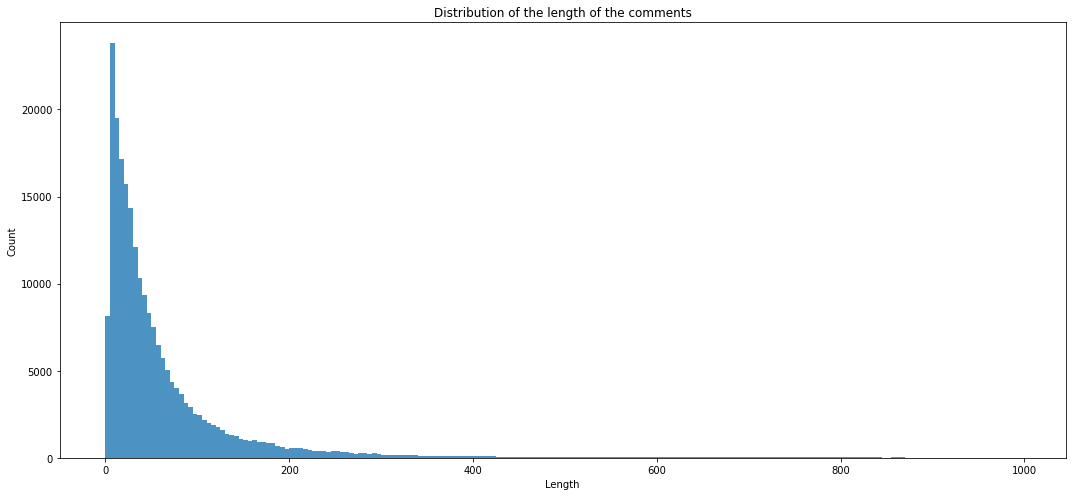

In [17]:
fig,ax =plt.subplots(figsize=(15,7))

bin_zoom = range(0,1000, 5)

ax.hist(complete['Word_Counts'], bins=bin_zoom, alpha=0.8)
ax.set_xlabel("Length")
ax.set_ylabel("Count")
ax.set_title("Distribution of the length of the comments")

plt.tight_layout()
plt.show()

In [18]:
print('mode:   ', mode(complete['Word_Counts']))
print('median: ', np.median(complete['Word_Counts']))
print('mean:    {:.2f}'.format(np.mean(complete['Word_Counts'])))
print('max:    ', max(complete['Word_Counts']))
print('percentiles:',[(str(p)+'%', np.percentile(complete['Word_Counts'],p)) for p in range(75,101,5)]) 

mode:    6
median:  35.0
mean:    66.59
max:     3750
percentiles: [('75%', 74.0), ('80%', 90.0), ('85%', 113.0), ('90%', 150.0), ('95%', 228.0), ('100%', 3750.0)]


Since it is a right-skewed distribution we have  $mode < median < mean$.

We have huge outlier (some comments exceed a thousand words) and so the mean is highly affected by them. However, taking a look at the percentiles we immediately notice that the vast majority of the comments fall within 200 words.

<br>

**Comments length distribution grouped by categories**

Now we show the same distribution but grouped by categories. The aim is to see what are the bigger ones and see whether the distribution remains the same for each category in terms of proportion.

In [19]:
comm = complete["clean_com"]
labels = complete[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]

In the following line of codes we decide to categorize as others the comments that does not belong to any of the class of toxicity labelled before and we built a new column that will behave as indicator function (1 if is others (i.e. unlabeled), 0 if is not)

In [20]:
others = []
for i in range(labels.shape[0]):
    if labels.iloc[i,:].sum() == 0:
        others.append(1)
    else:
        others.append(0)
se = pd.Series(others)
labels['others'] = se.values.tolist()
complete["others"] = se.values.tolist()
complete

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_com,Word_Counts,others
0,249153143547788,No need to follow this Policy Taivo instead of...,0,0,0,0,0,0,no need to follow this policy taivo instead of...,73,1
1,370084287833724,"""\n\nIs this person cuchullian a member of the...",0,0,0,0,0,0,is this person cuchullian a member of the klu ...,210,1
2,463311984751990,"""\n\nWhilst I don't agree with your reasoning,...",0,0,0,0,0,0,whilst i do not agree with your reasoning i am...,302,1
3,555281658565433,"December 2008 (UTC)\n\nWell said, I had exactl...",0,0,0,0,0,0,december 2008 utc well said i had exactly the ...,19,1
4,677031090441076,"""Awesome, thanks for taking the time to do so,...",0,0,0,0,0,0,awesome thanks for taking the time to do so lo...,41,1
...,...,...,...,...,...,...,...,...,...,...,...
223496,fff8f64043129fa2,":Jerome, I see you never got around to this…! ...",0,0,0,0,0,0,jerome i see you never got around to this i m ...,108,1
223497,fff9d70fe0722906,==Lucky bastard== \n http://wikimediafoundatio...,0,0,0,0,0,0,heh you are famous now i kida envy that congrats,10,1
223498,fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...,0,0,0,0,0,0,you want to speak about gays and not about rom...,10,1
223499,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1,0,1,0,1,0,mel gibson is a nazi bitch who makes shitty mo...,27,0


To go deeper in the analysis of the lenght of the comments, we try to see if the distribution of the length differs considering comments that belong to different classes.
In order to do so, we built overlapping histograms, each of them representing the length distribution of each of the classes. 

The following code builds up two histograms: the first one on the left considers our six categories plus the comments classified as others, while the second one on the right considers the six categories only.

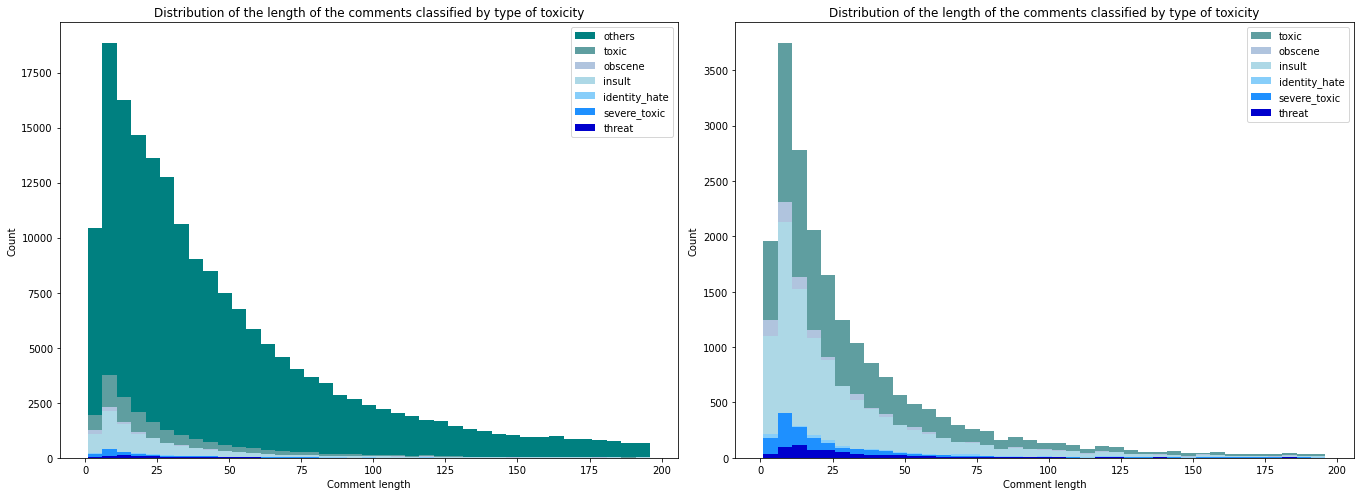

In [21]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(19,7))
bin_label = range(1,200,5)

# left histogram with others / unlabeled comments
ax1.hist(complete[complete['others']==1]['Word_Counts'], bins = bin_label, alpha=1, color="#008080")
ax1.hist(complete[complete['toxic']==1]['Word_Counts'], bins = bin_label, alpha=1, color="#5F9EA0")
ax1.hist(complete[complete['obscene']==1]['Word_Counts'], bins = bin_label, alpha=1, color="#B0C4DE")
ax1.hist(complete[complete['insult']==1]['Word_Counts'], bins = bin_label, alpha=1, color="#ADD8E6")
ax1.hist(complete[complete['identity_hate']==1]['Word_Counts'], bins = bin_label, alpha=1, color="#87CEFA")
ax1.hist(complete[complete['severe_toxic']==1]['Word_Counts'], bins = bin_label, alpha=1, color="#1E90FF")
ax1.hist(complete[complete['threat']==1]['Word_Counts'], bins = bin_label, alpha=1, color="#0000CD")
ax1.set_xlabel('Comment length')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of the length of the comments classified by type of toxicity')
ax1.legend(("others",'toxic', 'obscene', 'insult','identity_hate','severe_toxic','threat'))

# right histogram without others / unlabeled comments
ax2.hist(complete[complete['toxic']==1]['Word_Counts'], bins = bin_label, alpha=1, color="#5F9EA0")
ax2.hist(complete[complete['obscene']==1]['Word_Counts'], bins = bin_label, alpha=1, color="#B0C4DE")
ax2.hist(complete[complete['insult']==1]['Word_Counts'], bins = bin_label, alpha=1, color="#ADD8E6")
ax2.hist(complete[complete['identity_hate']==1]['Word_Counts'], bins = bin_label, alpha=1, color="#87CEFA")
ax2.hist(complete[complete['severe_toxic']==1]['Word_Counts'], bins = bin_label, alpha=1, color="#1E90FF")
ax2.hist(complete[complete['threat']==1]['Word_Counts'], bins = bin_label, alpha=1, color="#0000CD")
ax2.set_xlabel('Comment length')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of the length of the comments classified by type of toxicity')
ax2.legend(('toxic', 'obscene', 'insult','identity_hate','severe_toxic','threat'))


plt.tight_layout()
plt.show()

Observing the two plot, one considering also the "others" class and the other excluding it, we can conclude that the distribution of the length of the comments seems to be approximately the same (shape, mode and skewness) regardless of the classes to which the comments belong. 

### **Frequency of classes of toxicity**

Let us now focus the attention on the frequency of the different labels in the available dataset. Observe that the sum of the different counts is greater than the total number of comments in the dataset, due to the fact that comments simultaneously belonging to multiple classes are counted more than once, one for each class they belong to.

In [22]:
labels.sum()

toxic             21375
severe_toxic       1961
obscene           12133
threat              689
insult            11299
identity_hate      2117
others           201042
dtype: int64

It is easy to notice that the different classes of comments are clearly unbalanced. Indeed, there is a huge prevalence of non-toxic comments (more than 200k comments) relative to the toxic ones, that all together sum up to around 50k. In particular, some categories of toxicity, such as the `threat` one, accounts for a very small number of comments. 

In order to better visualize this unbalance, let us plot the counts for each category through a histogram, first considering also the non-toxic comments and then focusing just on the toxic ones.

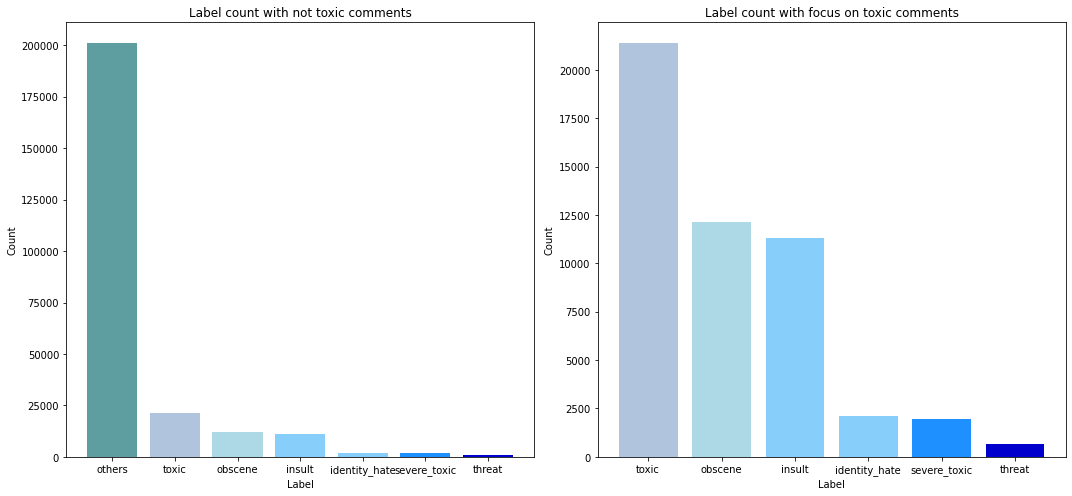

In [23]:
c = labels.sum()
counts = c.sort_values(ascending=False)
indexes = counts.index
bad_count = pd.DataFrame({"Label": list(indexes), "Count": list(counts)})

fig,(ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,7))

ax1.bar(bad_count["Label"], bad_count["Count"], 
        color=["#5F9EA0", "#B0C4DE", "#ADD8E6", "#87CEFA", "#87CEFA", "#1E90FF", "#0000CD"])
ax1.set_xlabel("Label")
ax1.set_ylabel("Count")
ax1.set_title("Label count with not toxic comments")

ax2.bar(bad_count.iloc[1:,0], bad_count.iloc[1:,1],
       color=["#B0C4DE", "#ADD8E6", "#87CEFA", "#87CEFA", "#1E90FF", "#0000CD"])
ax2.set_xlabel("Label")
ax2.set_ylabel("Count")
ax2.set_title("Label count with focus on toxic comments")

plt.tight_layout()
plt.show()

The unbalance among the different classes is particularly evident. This will for sure affect the analyses related to the evaluation of the models that will be presented later. 

### **Tokenization and Stopwords**



Tokenization is the first step in handling a language for NLP, actually consisting in breaking the stream of characters into tokens (i.e. words). It is a fundamental operation in order to perform all the other potential operations related to the analysis of text.

Dealing with a dataset of English comments, we load from the library `SpaCy` the basic model of medium size for English language in order to perform the following analysis on text.

In [24]:
nlp = spacy.load('en_core_web_md', disable = 'parser')

# Tokenization on full text cleaned
complete['Words'] = complete['clean_com'].apply(lambda x:str(x).split())

#### **Stopwords**

The first analysis we perform is related to the identification of the meaningless / less relevant words for our classification goal, in order to focus the attention only on the most significant words four our purpose.

To do so, we identify the most frequent words in the dataset, both considering and not considering the so called stopwords, that is a default set of common words provided by SpaCy. 

In [25]:
# Count number of times words appear in the text
count_stop = Counter([word for text in complete['Words'] for word in text if len(word)>2])

# Collect the 20 most common words
top_stop = pd.DataFrame(count_stop.most_common(20), columns=['Word','Count'])

stopwords = nlp.Defaults.stop_words

# Remove stopwords from text
complete['text_noStopWords'] = [' '.join([w for w in x.split() if w not in stopwords]) 
    for x in complete['clean_com'].tolist()]

# Tokenization on text without default stopwords
complete['Words_noStop'] = complete['text_noStopWords'].apply(lambda x:str(x).split())

# Count number of times words appear in the text
count_nostop = Counter([word for text in complete['Words_noStop'] for word in text if len(word)>2])

# Collect the 20 most common words (without stopwords)
top_nostop = pd.DataFrame(count_nostop.most_common(20), columns=['Word','Count'])

Let us visualize the results:

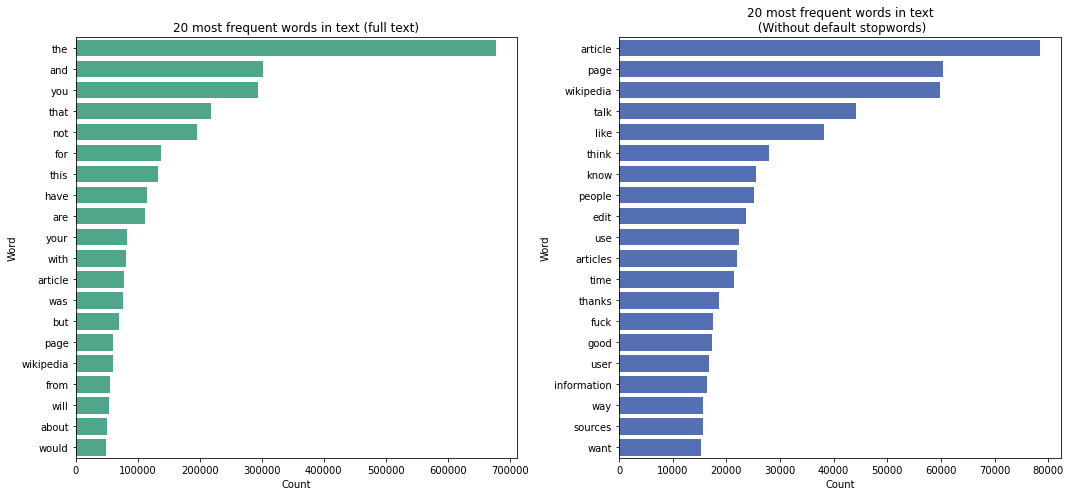

In [26]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,7))
sns.barplot(y='Word',x='Count',data=top_stop,color='#40B491',ax=ax[0]).set_title("20 most frequent words in text (full text)")
sns.barplot(y='Word',x='Count',data=top_nostop,color='#446AC2',ax=ax[1]).set_title("20 most frequent words in text\n (Without default stopwords)")
plt.tight_layout()
plt.show()

Once we removed the stopwrods from the comments, it is now interesting to see the most frequent words for each class of toxicity.

In [27]:
# Select all the comments belonging to a specific label
toxic = complete['toxic'] == 1
severe_toxic = complete['severe_toxic'] == 1
obscene = complete['obscene'] == 1
threat = complete['threat'] == 1
insult = complete['insult'] == 1
identity_hate = complete['identity_hate'] == 1
complete["others"] = labels["others"]
others = complete["others"] == 1

# Count the number of times words appear in each label
# Collect the 20 most common words for each label
top_toxic = Counter([word for text in complete[toxic]['Words_noStop'] for word in text])
top_toxic_df=pd.DataFrame(top_toxic.most_common(20),columns=['Word','Count'])

top_severe_toxic = Counter([word for text in complete[severe_toxic]['Words_noStop'] for word in text])
top_severe_toxic_df=pd.DataFrame(top_severe_toxic.most_common(20),columns=['Word','Count'])

top_obscene = Counter([word for text in complete[obscene]['Words_noStop'] for word in text])
top_obscene_df=pd.DataFrame(top_obscene.most_common(20),columns=['Word','Count'])

top_threat = Counter([word for text in complete[threat]['Words_noStop'] for word in text])
top_threat_df=pd.DataFrame(top_threat.most_common(20),columns=['Word','Count'])

top_insult = Counter([word for text in complete[insult]['Words_noStop'] for word in text])
top_insult_df=pd.DataFrame(top_insult.most_common(20),columns=['Word','Count'])

top_identity_hate = Counter([word for text in complete[identity_hate]['Words_noStop'] for word in text])
top_identity_hate_df=pd.DataFrame(top_identity_hate.most_common(20),columns=['Word','Count'])

top_others = Counter([word for text in complete[others]['Words_noStop'] for word in text])
top_others_df=pd.DataFrame(top_others.most_common(20),columns=['Word','Count'])

Visualizing the results:

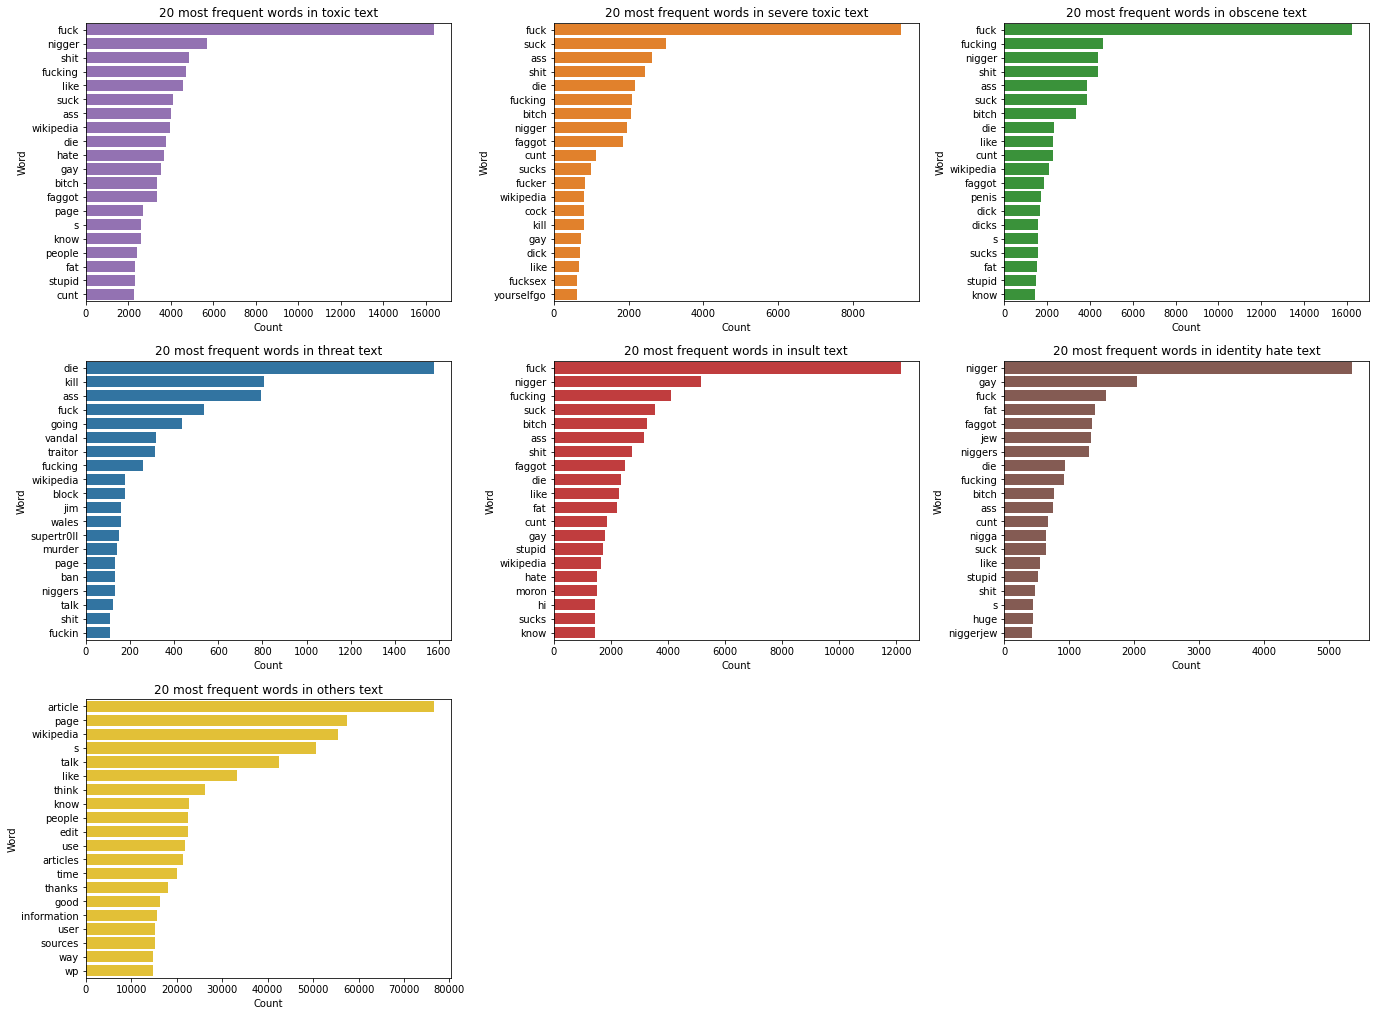

In [28]:
fig,ax=plt.subplots(nrows=3,ncols=3,figsize=(19,14), constrained_layout = True)
sns.barplot(y='Word',x='Count',data=top_toxic_df,color='#9467bd',ax=ax[0,0])
sns.barplot(y='Word',x='Count',data=top_severe_toxic_df,color='#ff7f0e',ax=ax[0,1])
sns.barplot(y='Word',x='Count',data=top_obscene_df ,color='#2ca02c',ax=ax[0,2])
sns.barplot(y='Word',x='Count',data=top_threat_df ,color='#1f77b4',ax=ax[1,0])
sns.barplot(y='Word',x='Count',data=top_insult_df ,color='#d62728',ax=ax[1,1])
sns.barplot(y='Word',x='Count',data=top_identity_hate_df ,color='#8c564b',ax=ax[1,2])
sns.barplot(y='Word',x='Count',data=top_others_df ,color='#ffd11a',ax=ax[2,0])
ax[0,0].set_title("20 most frequent words in toxic text")
ax[0,1].set_title("20 most frequent words in severe toxic text")
ax[0,2].set_title("20 most frequent words in obscene text")
ax[1,0].set_title("20 most frequent words in threat text")
ax[1,1].set_title("20 most frequent words in insult text")
ax[1,2].set_title("20 most frequent words in identity hate text")
ax[2,0].set_title("20 most frequent words in others text")
fig.delaxes(ax[2][1])
fig.delaxes(ax[2][2])
plt.show()

Looking at the most frequent words in comments belonging to the different labels, there are some common words that consequently are not relevant for discriminate among the different classes of toxicity, like "wikipedia" or "page". Therefore, additionally to the default stopwords, we decide to remove also these "customized" stopwords from our comments.

In [29]:
# Removing additional stopwords
my_stopwords = ["wikipedia","page","like","s","hi","di", "talk", "wrt","f","0","x","00"]
complete['clean_mystop'] = [' '.join([w for w in x.split() if w not in my_stopwords]) 
    for x in complete['clean_com'].tolist()]
complete['words_clean_mystop'] = complete['clean_mystop'].apply(lambda x:str(x).split())

Just to be sure, before proceeding we check that there are no empty strings even after stopwrds removal:

In [30]:
blanks_stop = 0 

for def_comment in complete["clean_mystop"]: 
    if type(def_comment)==str:            
        if def_comment.isspace():         
            blanks_stop +=1               

blanks_stop

0

#### **Correlation among classes of toxicity**

After defintely cleaning the comments, since a comment may belong to multiple classes of toxicity, iti may be interesting to investigate on the correlation among the different labels.

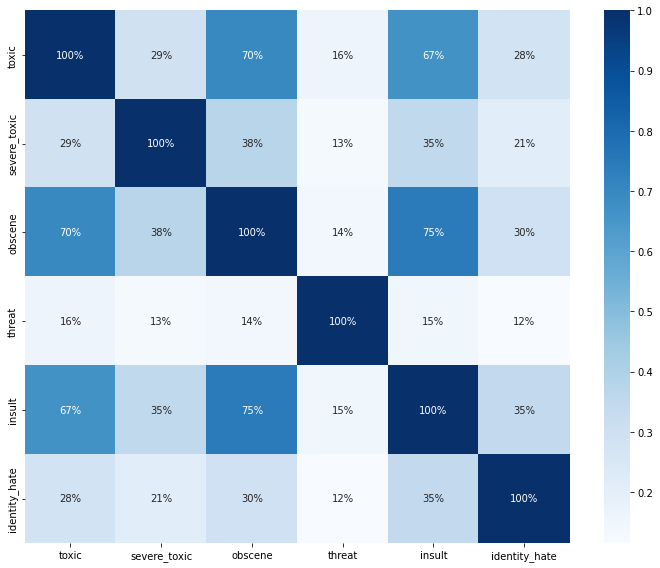

In [31]:
plt.figure(figsize = (10,8))
sns.heatmap(complete[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]].corr(),annot= True,fmt=".0%",cmap="Blues")
plt.tight_layout()
plt.show()

From the correlation matrix above, we can point out that:
- a comment that is toxic is more likely to be categorized also as obscene and insulting;
- the labels `threat` and `identity_hate` are carachterised by a really low correlation with the other labels. 

#### **Part of Speech (PoS)**

Among the analysis that Spacy does there is also the Part-of-Speech one.
In corpus linguistics, part-of-speech, also called grammatical tagging or word-category disambiguation, is the process of marking up a word in a text (corpus) as corresponding to a particular part of speech, based on both its definition and its context (i.e., its relationship with adjacent and related words in a phrase, sentence, or paragraph).
So that when we receive a token we are able to recognize each token if it a noun, verb, adjective ecc.
Words are organized in grammatical Classes. 
In English, a standard list is provided by Penn Tree Bank list (today: 36 classes).

In the following line of code we are interested in counting each token's part-of-speech in order to see which are the most common part-of speech in our comments.  

In [32]:
#POS - PART OF SPEECH
label = ["all","toxic","severe_toxic","obscene","threat","insult","identity_hate","others"]
doc = {"all":[],"toxic":[],"severe_toxic":[],"obscene":[],"threat":[],"insult":[],"identity_hate":[],"others":[]}
for clas in label:
    if clas == "all":
        df = complete['clean_mystop']
    else:
        df = complete['clean_mystop'].loc[complete[clas] == 1].reset_index(drop=True)
    for i in range(len(df[:1000])):
        doc0 = nlp(df[i])
        for token in doc0:
            doc[clas].append(token)

In [33]:
#Count of occurences for the different part of speech
tokenpos = []
for token in doc["all"]: 
    tokenpos.append(token.pos_) #creating a list of pos to apply counter object in the following code

tokenposdict = Counter(tokenpos)
total = sum(tokenposdict.values())
for key, value in sorted(tokenposdict.items(), key=lambda pair: pair[1], reverse=True): 
  print(f'{key:{5}} {round(100*value/total,2):{5}}% {spacy.explain(key):{25}}')

NOUN  18.43% noun                     
VERB  14.03% verb                     
DET   11.76% determiner               
ADP    9.56% adposition               
PRON   8.19% pronoun                  
ADJ    7.14% adjective                
AUX    7.09% auxiliary                
PROPN   6.2% proper noun              
ADV    5.57% adverb                   
PART   3.38% particle                 
CCONJ   3.0% coordinating conjunction 
SCONJ  2.81% subordinating conjunction
NUM    2.06% numeral                  
INTJ    0.7% interjection             
X      0.07% other                    
PUNCT  0.01% punctuation              
SYM     0.0% symbol                   


From the results we can clearly see that the most common tokens are respectively Nouns, Verb, Determiner and Adposition that account for 55% of the total number of tokens.

Considering just the nouns we have in our comments, we visualize the most frequent tokens through a WordCloud.
This representation shows the noun's tokens proportionally in size to their frequency, so that is easy to see the most relevants.

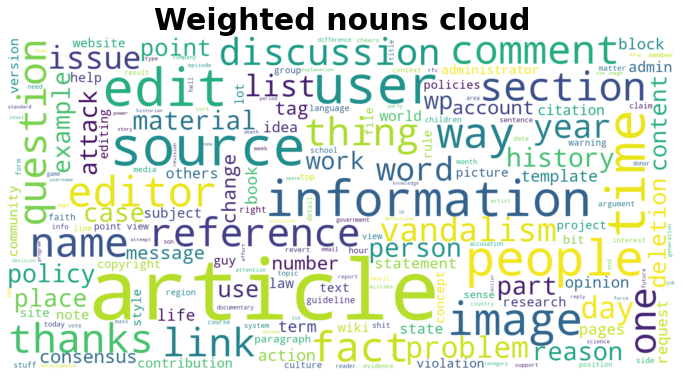

In [34]:
# Perform fine-grained PoS
temp = []
for token in doc["all"]:
    if token.pos_ == "NOUN":
      temp.append(str(token).strip())

# Creatin the word cloud
nouns = " ".join(temp)
wordcloud = WordCloud(
    background_color = 'white', 
    width = 1600, height = 800,
    max_font_size = 200, 
    random_state = 0
).generate(nouns[:]) 

plt.figure(figsize=(12,10))
plt.title(
    'Weighted nouns cloud',
    fontweight = 'bold',
    fontsize=30
)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Looking at the WordCloud the terms that pops up are "article", "source", "comment", "people", "user", "edit", all nouns in some sense related to the world of "comments on the web".
 

We consider the previous analysis in this case focusing on the different part of speech tags:

In [35]:
#Count of occurences for the different part of speech tags
tokentag = []
for token in doc["all"]:
    tokentag.append(token.tag_)
tokentagdict = Counter(tokentag)
total = sum(tokentagdict.values())
for key, value in sorted(tokentagdict.items(), key=lambda pair: pair[1], reverse=True): #sorted descending relatively to the frequency
    print(f'{key:{5}} {round(100*value/total,2):{5}}% {spacy.explain(key)}')

NN    14.21% noun, singular or mass
IN    11.94% conjunction, subordinating or preposition
DT      9.5% determiner
PRP    7.11% pronoun, personal
JJ     6.69% adjective
RB     6.35% adverb
NNP    6.03% noun, proper singular
VB      5.3% verb, base form
NNS    4.59% noun, plural
VBP    3.67% verb, non-3rd person singular present
VBZ    3.35% verb, 3rd person singular present
CC      3.0% conjunction, coordinating
VBN     2.7% verb, past participle
VBD    2.17% verb, past tense
VBG    2.15% verb, gerund or present participle
CD     2.06% cardinal number
TO     1.86% infinitival "to"
MD     1.79% verb, modal auxiliary
PRP$   1.51% pronoun, possessive
UH      0.7% interjection
WDT    0.64% wh-determiner
WRB    0.51% wh-adverb
WP     0.48% wh-pronoun, personal
RP     0.42% adverb, particle
JJR     0.3% adjective, comparative
EX     0.23% existential there
NNPS   0.18% noun, proper plural
RBR    0.17% adverb, comparative
JJS    0.15% adjective, superlative
PDT    0.11% predeterminer
RBS    0

#### **Named Entity Relationship (NER)**

Also the Named Entity Recognition is one of the analyses that the engine performs on top of the text.
The goal of Named Entity Recognition is to identify entities that have a proper noun that identify a specific concept and to identify entities that are related to measures

Due to the big amounts of comments we decide to visualize NER only on the first 30 comments we have.


In [36]:
dataset_list = list(complete["clean_mystop"][0:30])
text_ner = str(dataset_list)
doc_ner = nlp(text_ner)
spans = list(doc_ner.ents)
colors = {'ORG': 'linear-gradient(90deg, #aa9cfc, #fc9ce7)', 'PERSON': 'radial-gradient(yellow, green)','DATE':'radial-gradient(blue)'}
options = {'colors':colors}
displacy.render(doc_ner, style='ent', jupyter=True)

The main observation that we can point out from visualizing NER on some
of our comments is the fact that most of the token that are "classified" as Person 
are instead Users. 
Since we are dealing with Wikipedia's comments, most of the time, the users
refer to each others considering Username instead of Proper Noun.

In [ ]:
complete.to_csv("complete.csv", index=False)

## 3. **NEURAL NETWORK APPROACH**

In [ ]:
# loading the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout,Input
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.test import gpu_device_name
from keras.backend import clear_session
from keras.models import load_model
from sklearn.metrics import multilabel_confusion_matrix as mcm, classification_report
import os
import tensorflow as tf
import warnings
import random
warnings.filterwarnings("ignore")
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
tf.get_logger().setLevel('ERROR')

In [ ]:
# loading the cleaned dataset
path = "complete.csv"
complete = pd.read_csv(path)

After the data cleaning and its exploration, the final complete dataset where we saved all the results looks like this:

In [ ]:
complete.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_com,Word_Counts,Words,text_noStopWords,Words_noStop,others,clean_mystop,words_clean_mystop
0,249153143547788,No need to follow this Policy Taivo instead of...,0,0,0,0,0,0,no need to follow this policy taivo instead of...,73,"['no', 'need', 'to', 'follow', 'this', 'policy...",need follow policy taivo instead following far...,"['need', 'follow', 'policy', 'taivo', 'instead...",1,no need to follow this policy taivo instead of...,"['no', 'need', 'to', 'follow', 'this', 'policy..."
1,370084287833724,"""\n\nIs this person cuchullian a member of the...",0,0,0,0,0,0,is this person cuchullian a member of the klu ...,210,"['is', 'this', 'person', 'cuchullian', 'a', 'm...",person cuchullian member klu klux klan reincar...,"['person', 'cuchullian', 'member', 'klu', 'klu...",1,is this person cuchullian a member of the klu ...,"['is', 'this', 'person', 'cuchullian', 'a', 'm..."
2,463311984751990,"""\n\nWhilst I don't agree with your reasoning,...",0,0,0,0,0,0,whilst i do not agree with your reasoning i am...,302,"['whilst', 'i', 'do', 'not', 'agree', 'with', ...",whilst agree reasoning happy add reference rea...,"['whilst', 'agree', 'reasoning', 'happy', 'add...",1,whilst i do not agree with your reasoning i am...,"['whilst', 'i', 'do', 'not', 'agree', 'with', ..."
3,555281658565433,"December 2008 (UTC)\n\nWell said, I had exactl...",0,0,0,0,0,0,december 2008 utc well said i had exactly the ...,19,"['december', '2008', 'utc', 'well', 'said', 'i...",december 2008 utc said exactly good reason 22 ...,"['december', '2008', 'utc', 'said', 'exactly',...",1,december 2008 utc well said i had exactly the ...,"['december', '2008', 'utc', 'well', 'said', 'i..."
4,677031090441076,"""Awesome, thanks for taking the time to do so,...",0,0,0,0,0,0,awesome thanks for taking the time to do so lo...,41,"['awesome', 'thanks', 'for', 'taking', 'the', ...",awesome thanks taking time look forward runnin...,"['awesome', 'thanks', 'taking', 'time', 'look'...",1,awesome thanks for taking the time to do so lo...,"['awesome', 'thanks', 'for', 'taking', 'the', ..."


### **SETTING THE MODEL**

Since having text data, the position of each word (token) in a sentence will be a relevant aspect to be considered, therefore a simple feed forward neural network would not perform well. Indeed, we need for an algorithm that takes into consideration the position of each token within the text. One of the networks that can perform this task is the LSTM.

The LSTM is a particular type of Recurrent Neural Network that overcomes the issue of short term memory of RNNs by exploiting a combination of activation functions thanks to which the cell takes a smooth forget behavior output from the neuron at previous state.


Alternatively to the LSTM, some other algorithms could be implemented, like the Gated Recurrent Unit (GRU), which has a similar structure to LSTM but reduces the number of computations performed by the network.

The variables we will deal with from this point on will be:

- the ones related to the 6 initial labels (`toxic`, `severe_toxic`, `obscene`, `threat`, `insult`, `identity_hate`), that will define our response $y$;
- the one containing the cleaned comments, `clean_mystop`, that will identify our independent variable $X$.


Since at the beginning we merged the train and the test set in order to analyze the whole dataset, we now have to split again the dataset at the same point, defining the 4 variables `X_train`, `y_train`, `X_test` and `y_test`.

In [ ]:
X = pd.DataFrame(complete["clean_mystop"], columns=["clean_mystop"]).astype(str)
y = complete[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]

X_train = X.iloc[:159571]
X_test = X.iloc[159571:]

y_train = y.iloc[:159571]
y_test = y.iloc[159571:]

print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape:  {X_test.shape},  y_test shape:  {y_test.shape}')

X_train shape: (159571, 1), y_train shape: (159571, 6)
X_test shape:  (63930, 1),  y_test shape:  (63930, 6)


In order to prepare the text for the neural network approach, first of all we perform a kind of tokenization performed by keras, which does not properly consist in a real tokenization, but rather assigns a number to each token, creating a sequence of numbers. The size of the unique indexes that we are going to provide to the system, i.e. the number of features for the neural network, is represented by the variable `vocab_size`.

In [ ]:
# Load the keras tokenizer
tokenizer = Tokenizer(split = ' ')

# Apply the tokenizer to the cleaned comments
tokenizer.fit_on_texts(X["clean_mystop"].values)

# Length of the vocabulary
vocab_size = len(tokenizer.word_index) + 1 
vocab_size

229194

Since the network takes as inputs sequences of tokens of the same length, we must set a maximum length for our sequences. Through the study of the distribution of the lengths of our comments, we discover that the 95% of the comments have a length lower than 224 words.

In [ ]:
# Creating sequences
X_train = tokenizer.texts_to_sequences(X_train["clean_mystop"].values)
X_test = tokenizer.texts_to_sequences(X_test["clean_mystop"].values)

# Distribution of the lengths
seq_len = np.array([len(s) for s in X_train] + [len(s) for s in X_test]) 
print([(str(p)+'%', np.percentile(seq_len,p)) for p in range(75,101,5)])

[('75%', 73.0), ('80%', 88.0), ('85%', 110.0), ('90%', 148.0), ('95%', 224.0), ('100%', 3750.0)]


Just to be sure, we choose to set the max sequence length equal to 225 and we pad our sequences:

- if a sequence is shorter than the maxmimum length, the function `pad_sequences()` fills with zero values the missing positions of the sequence until the sequence itself reaches the value of the max length;
- if a sequence is longer than the maximum length, the `pad_sequences()` function drops the sequence at the `max_sequence_len`-th element.

In [ ]:
max_sequence_len = 225
X_train = pad_sequences(X_train, maxlen = max_sequence_len)
X_test = pad_sequences(X_test, maxlen = max_sequence_len)

Once we prepared our $X$ variable, we need to process also our response, i.e. the 6 classes of toxicity.

In [ ]:
# First output
y1_train = y_train[["toxic"]].values
y1_test =  y_test[["toxic"]].values

# Second output
y2_train = y_train[["severe_toxic"]].values
y2_test =  y_test[["severe_toxic"]].values

# Third output
y3_train = y_train[["obscene"]].values
y3_test =  y_test[["obscene"]].values

# Fourth output
y4_train = y_train[["threat"]].values
y4_test =  y_test[["threat"]].values

# Fifth output
y5_train = y_train[["insult"]].values
y5_test =  y_test[["insult"]].values

# Sixth output
y6_train = y_train[["identity_hate"]].values
y6_test =  y_test[["identity_hate"]].values

Our goal is related to a multi-label classification task, that means that a comment can belong to multiple labels simultaneously, therefore we can interpret our model as the combination of 6 binary classification models.

Basically, we want to train a model to be able to identify if a comment should be categorized as toxic, severe toxic, obscene, insult, threat or identity hate, but with the possibility for a comment to be classified under multiple classes simultaneously. Hence, we prepare a model that evaluates if a comment can belong to each class (actually returning 6 different outputs per comment, one for each label), analyzing them one at a time according to a **sigmoid** activation function.

Indeed, the sigmoid activation function actually returns a probability for a comment to be categorized according to a specific label: when this probability is greater than a threshold (traditionally identified in 0.5), the model will assign that comment to that specific label, and this procedure will be followed for each comment for each possible label.

As optimizer, we use ***Adam*** since it is the one with the best perfomances when dealing with this kind of tasks (it makes the learning rate dynamic to avoid local minima points).

In [ ]:
clear_session()
# vocab_size = 229157
max_sequence_len = 225 # = X_train.shape[1]
embed_dim = 256
lstm_out = 256

input_1 = Input(shape=(max_sequence_len,))
embedding_layer = Embedding(input_dim = vocab_size, output_dim = embed_dim, input_length = max_sequence_len)(input_1)
LSTM_Layer1 = LSTM(lstm_out)(embedding_layer)
output1 = Dense(1, activation='sigmoid', name="dense_1")(LSTM_Layer1)
output2 = Dense(1, activation='sigmoid', name="dense_2")(LSTM_Layer1)
output3 = Dense(1, activation='sigmoid', name="dense_3")(LSTM_Layer1)
output4 = Dense(1, activation='sigmoid', name="dense_4")(LSTM_Layer1)
output5 = Dense(1, activation='sigmoid', name="dense_5")(LSTM_Layer1)
output6 = Dense(1, activation='sigmoid', name="dense_6")(LSTM_Layer1)

model = Model(inputs=input_1, 
              outputs=[output1, output2, output3, output4, output5, output6])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 225)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 225, 256)     58673664    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 256)          525312      ['embedding[0][0]']              
                                                                                                  
 dense_1 (Dense)                (None, 1)            257         ['lstm[0][0]']                   
                                                                                              

In order to overcome the risk of overfitting of the model with respect to the training set, we have set an early stopping rule. **Early Stopping** is a mechanism that monitors the behavior of a variable along the training, stopping it when the improvement is lower than a defined value. In our case, the Early Stopping mechanism monitors the validation loss and stops training if there isn't any significant improvement for 3 consecutive epochs (patience = 3). 

Additionally, we add a variable `checkpoint_cb` in order to save the best possible model.

In [ ]:
early_stopping_callback = EarlyStopping(monitor = "val_loss", patience = 3, verbose = 1, mode = "auto", restore_best_weights = True)
checkpoint_cb = ModelCheckpoint("nlp.h5", save_best_only=True)

We set the batch size equal to 256 and we run the training model.

*(We chose a quite large batch size since the dataset is really unbalanced in favor of unlabeled comments, therefore by including more comments in each batch we try to reduce the risk of having in some batches only unlabeled comments, with the goal to improve the training.)*

In [ ]:
batch_size = 256
model_fit = model.fit(x=X_train, y=[y1_train, y2_train, y3_train, y4_train, y5_train, y6_train], 
                      epochs = 100, 
                      batch_size = batch_size, 
                      callbacks = [early_stopping_callback, checkpoint_cb],
                      validation_split = 0.1,
                      verbose = 1)

Epoch 1/100
561/561 [==============================] - 61s 102ms/step - loss: 0.5104 - dense_1_loss: 0.1818 - dense_2_loss: 0.0389 - dense_3_loss: 0.1099 - dense_4_loss: 0.0226 - dense_5_loss: 0.1147 - dense_6_loss: 0.0424 - dense_1_acc: 0.9423 - dense_2_acc: 0.9892 - dense_3_acc: 0.9658 - dense_4_acc: 0.9959 - dense_5_acc: 0.9623 - dense_6_acc: 0.9903 - val_loss: 0.3122 - val_dense_1_loss: 0.1112 - val_dense_2_loss: 0.0263 - val_dense_3_loss: 0.0615 - val_dense_4_loss: 0.0139 - val_dense_5_loss: 0.0677 - val_dense_6_loss: 0.0317 - val_dense_1_acc: 0.9597 - val_dense_2_acc: 0.9903 - val_dense_3_acc: 0.9762 - val_dense_4_acc: 0.9974 - val_dense_5_acc: 0.9723 - val_dense_6_acc: 0.9913
Epoch 2/100
561/561 [==============================] - 57s 102ms/step - loss: 0.2766 - dense_1_loss: 0.0921 - dense_2_loss: 0.0231 - dense_3_loss: 0.0526 - dense_4_loss: 0.0140 - dense_5_loss: 0.0645 - dense_6_loss: 0.0303 - dense_1_acc: 0.9670 - dense_2_acc: 0.9902 - dense_3_acc: 0.9795 - dense_4_acc: 0.99

The Early Stopping stopped the training after just 5 epochs. It is now possible to test the model on the test set.

### **TESTING THE MODEL**

In [ ]:
batch_size = 256
newmodel = load_model('nlp.h5')
score = newmodel.evaluate(x=X_test, y=[y1_test, y2_test, y3_test, y4_test, y5_test, y6_test],batch_size=batch_size, verbose=0)
print(f"test_overal_loss: {score[0]}")

labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
i = 1
for label in labels:
    print(f"{i}) {label:{14}}=> test_loss: {score[i]:.6f}, test_acc: {score[i+6]:.3f}")
    i += 1

test_overal_loss: 0.49179181456565857
1) toxic         => test_loss: 0.207357, test_acc: 0.910
2) severe_toxic  => test_loss: 0.019459, test_acc: 0.994
3) obscene       => test_loss: 0.104015, test_acc: 0.958
4) threat        => test_loss: 0.015501, test_acc: 0.997
5) insult        => test_loss: 0.105372, test_acc: 0.958
6) identity_hate => test_loss: 0.040089, test_acc: 0.989


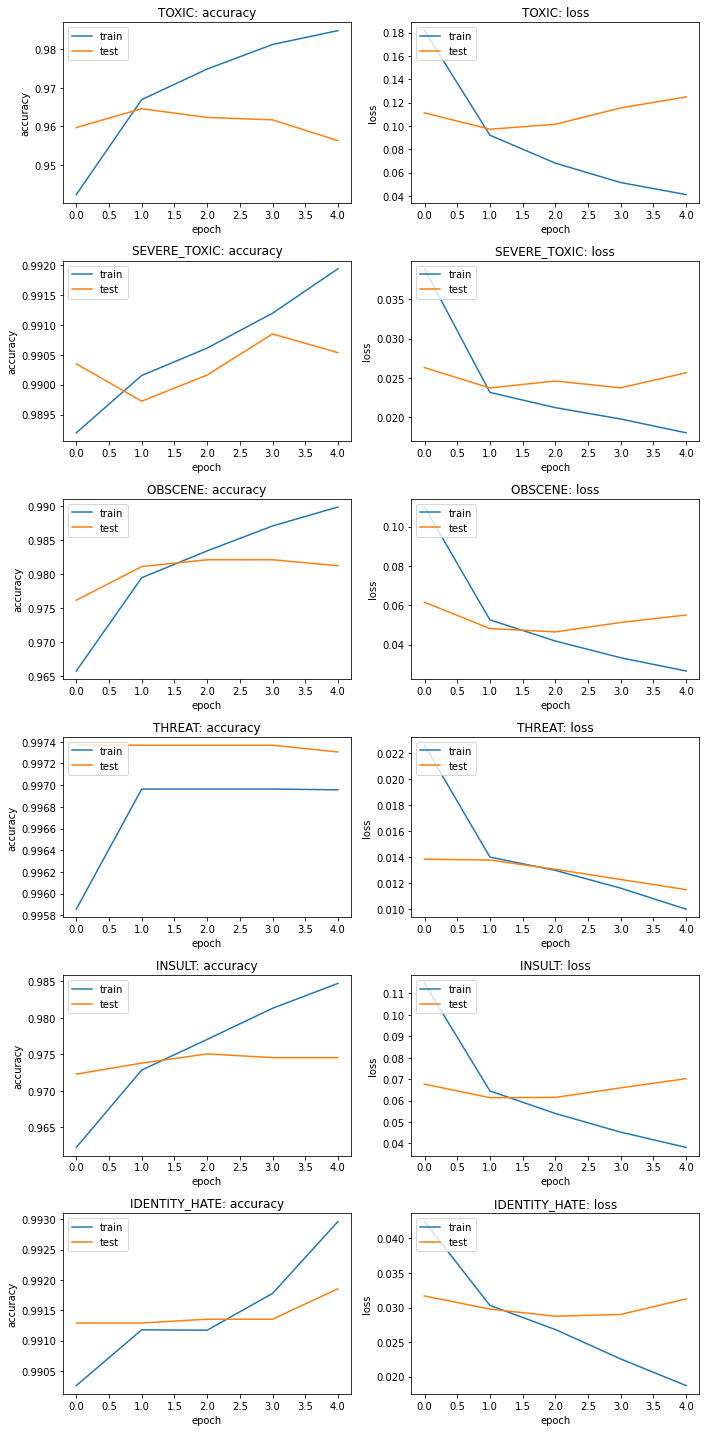

In [ ]:
f, ax = plt.subplots(6, 2, figsize=(10,20))
for i in range(6):
    for j in range(2):
        if j == 0:
            ax[i,j].plot(model_fit.history[f'dense_{i+1}_acc'])
            ax[i,j].plot(model_fit.history[f'val_dense_{i+1}_acc'])
            ax[i,j].set_title(f'{labels[i].upper()}: accuracy')
            ax[i,j].set_ylabel('accuracy')
            ax[i,j].set_xlabel('epoch')
            ax[i,j].legend(['train','test'], loc='upper left')
        else:
            ax[i,j].plot(model_fit.history[f'dense_{i+1}_loss'])
            ax[i,j].plot(model_fit.history[f'val_dense_{i+1}_loss'])
            ax[i,j].set_title(f'{labels[i].upper()}: loss')
            ax[i,j].set_ylabel('loss')
            ax[i,j].set_xlabel('epoch')
            ax[i,j].legend(['train','test'], loc='upper left')

f.tight_layout()        

The first metrics we focus on are the loss and the accuracy, which seem to follow a good trend, since the loss tends to decrease e the accuracy has a positive trend.

However, it is fundamental to recall that the dataset on which we worked was strongly unbalanced in favor of some labels. This moved our focus on other metrics of interest, such as the recall, the precision and the F1-score. 

Additionally, another issue related to the dataset was that most of the comments were actually unlabeled, not belonging to any class of toxicity (actually, more than 85% of the total comments). This might have reduced the capability of the model to correctly categorize comments, especially for the less frequent labels, and consequently affecting the evaluation metrics.

Starting from the output probabilities, we build the labeled predictions setting as threshold a value of 0.5, and we focus on the classification report:

In [ ]:
predictions = newmodel.predict(X_test)
classes = []
i = 0
for pred in predictions:
    classes.append([])
    for pr in pred:
        if pr >= 0.5:
            classes[i].append(1)
        else:
            classes[i].append(0)
    i += 1
    
classes = np.array(classes)
classes = classes.T

In [ ]:
print(classification_report(y_test.values, classes))

              precision    recall  f1-score   support

           0       0.52      0.83      0.64      6081
           1       0.37      0.18      0.24       366
           2       0.61      0.76      0.68      3684
           3       0.00      0.00      0.00       211
           4       0.60      0.61      0.61      3422
           5       0.00      0.00      0.00       712

   micro avg       0.56      0.69      0.62     14476
   macro avg       0.35      0.40      0.36     14476
weighted avg       0.52      0.69      0.59     14476
 samples avg       0.07      0.07      0.07     14476



Despite the huge unbalance of the dataset in favor of unlabeled comments, the model works quite good at least for the most frequent labels, such as toxic (0), obscene (2) and insult (4), returning quite acceptable results even with a small of number of observations to be tested.

On the other hand, for the 3 remaining classes of toxicity (severe toxic (1), threat (3) and identity hate (5)), the model is not able to make correct evaluations for comments. These bad performances are for sure due both to the unbalance issue described above and to the very small number of comments that belonged to those labels.

The model might perform much better just by improving the quality of the dataset, for example by collecting more labeled comments and even more by trying to balance the frequency of the different classes of toxicity.

Since we do not have the possibility to add new comments to the dataset, let us try for a rebalancing of the dataset by remomving most of the non-labeled comments, so that all the other labeled comments increase their relevance in the dataset during the training of the model.

### **UNDERSAMPLING**

#### **Setting the dataset**

In [ ]:
X = pd.DataFrame(complete["clean_mystop"], columns=["clean_mystop"]).astype(str)
y = complete[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]

X_train = X.iloc[:159571]
X_test = X.iloc[159571:]

y_train = y.iloc[:159571]
y_test = y.iloc[159571:]

Let us define two functions to undersample from the training set a subset where the number of non-labeled comments is more balanced with respect to the other classes of toxicity, and re-run the model.

In [ ]:
def sample_together(n, X, y):
    rows = random.sample(np.arange(0,len(X.index)).tolist(),n)
    return X.iloc[rows,], y.iloc[rows,]

In [ ]:
def undersample(X, y, under = 0):
    y_min = y[complete.others == under]
    y_max = y[complete.others != under]
    X_min = X.filter(y_min.index,axis = 0)
    X_max = X.filter(y_max.index,axis = 0)

    X_under, y_under = sample_together(len(y_min.index), X_max, y_max)
    
    X = pd.concat([X_under, X_min]).sample(32450,random_state=200).reset_index(drop=True)
    y = pd.concat([y_under, y_min]).sample(32450,random_state=200).reset_index(drop=True)
    return X, y

X_train, y_train = undersample(X_train, y_train)

In [ ]:
X_train.shape, y_train.shape

((32450, 1), (32450, 6))

The training set now includes 32'450 comments, around 120k less than the whole training set, where all the removed comments did not belong to any class of toxicity. In this way, the labeled comments should become more relevant when training the model.

Let us go on with the re-definition of the (same) model and start the training:

#### **Setting the model**

In [ ]:
X = pd.concat([X_train,X_test])
X_train = tokenizer.texts_to_sequences(X_train["clean_mystop"].values)
X_test = tokenizer.texts_to_sequences(X_test["clean_mystop"].values)

In [ ]:
# Load the keras tokenizer
tokenizer = Tokenizer(split = ' ')

# Apply the tokenizer to the cleaned comments
tokenizer.fit_on_texts(X["clean_mystop"].values)

# Length of the vocabulary
vocab_size = len(tokenizer.word_index) + 1 

In [ ]:
max_sequence_len = 225
X_train = pad_sequences(X_train, maxlen = max_sequence_len)
X_test = pad_sequences(X_test, maxlen = max_sequence_len)

In [ ]:
# First output
y1_train = y_train[["toxic"]].values
y1_test =  y_test[["toxic"]].values

# Second output
y2_train = y_train[["severe_toxic"]].values
y2_test =  y_test[["severe_toxic"]].values

# Third output
y3_train = y_train[["obscene"]].values
y3_test =  y_test[["obscene"]].values

# Fourth output
y4_train = y_train[["threat"]].values
y4_test =  y_test[["threat"]].values

# Fifth output
y5_train = y_train[["insult"]].values
y5_test =  y_test[["insult"]].values

# Sixth output
y6_train = y_train[["identity_hate"]].values
y6_test =  y_test[["identity_hate"]].values

In [ ]:
clear_session()
# vocab_size = 141622
max_sequence_len = 225 # = X_train.shape[1]
embed_dim = 256
lstm_out = 256

input_1 = Input(shape=(max_sequence_len,))
embedding_layer = Embedding(input_dim = vocab_size, output_dim = embed_dim, input_length = max_sequence_len)(input_1)
LSTM_Layer1 = LSTM(lstm_out)(embedding_layer)
output1 = Dense(1, activation='sigmoid', name="dense_1")(LSTM_Layer1)
output2 = Dense(1, activation='sigmoid', name="dense_2")(LSTM_Layer1)
output3 = Dense(1, activation='sigmoid', name="dense_3")(LSTM_Layer1)
output4 = Dense(1, activation='sigmoid', name="dense_4")(LSTM_Layer1)
output5 = Dense(1, activation='sigmoid', name="dense_5")(LSTM_Layer1)
output6 = Dense(1, activation='sigmoid', name="dense_6")(LSTM_Layer1)

model = Model(inputs=input_1, 
              outputs=[output1, output2, output3, output4, output5, output6])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 225)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 225, 256)     36255232    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 256)          525312      ['embedding[0][0]']              
                                                                                                  
 dense_1 (Dense)                (None, 1)            257         ['lstm[0][0]']                   
                                                                                              

In [ ]:
early_stopping_callback = EarlyStopping(monitor = "val_loss", patience = 3, verbose = 1, mode = "auto", restore_best_weights = True)
checkpoint_cb = ModelCheckpoint("nlp.h5", save_best_only=True)

In [ ]:
batch_size = 256
model_fit = model.fit(x=X_train, y=[y1_train, y2_train, y3_train, y4_train, y5_train, y6_train], epochs = 100, batch_size = batch_size, callbacks = [early_stopping_callback, checkpoint_cb],validation_split = 0.1,verbose = 1)

Epoch 1/100
115/115 [==============================] - 15s 114ms/step - loss: 1.9463 - dense_1_loss: 0.5408 - dense_2_loss: 0.1870 - dense_3_loss: 0.4665 - dense_4_loss: 0.1024 - dense_5_loss: 0.4601 - dense_6_loss: 0.1895 - dense_1_acc: 0.7160 - dense_2_acc: 0.9471 - dense_3_acc: 0.7862 - dense_4_acc: 0.9783 - dense_5_acc: 0.7941 - dense_6_acc: 0.9518 - val_loss: 1.5170 - val_dense_1_loss: 0.3945 - val_dense_2_loss: 0.1210 - val_dense_3_loss: 0.3994 - val_dense_4_loss: 0.0580 - val_dense_5_loss: 0.4038 - val_dense_6_loss: 0.1403 - val_dense_1_acc: 0.8203 - val_dense_2_acc: 0.9525 - val_dense_3_acc: 0.8376 - val_dense_4_acc: 0.9864 - val_dense_5_acc: 0.8388 - val_dense_6_acc: 0.9615
Epoch 2/100
115/115 [==============================] - 12s 108ms/step - loss: 1.2973 - dense_1_loss: 0.3233 - dense_2_loss: 0.1287 - dense_3_loss: 0.2986 - dense_4_loss: 0.0710 - dense_5_loss: 0.3246 - dense_6_loss: 0.1511 - dense_1_acc: 0.8662 - dense_2_acc: 0.9505 - dense_3_acc: 0.8785 - dense_4_acc: 0.98

The Early Stopping rule now stopped the training model after 8 epochs. It is now time to test the model through `X_test` and `y_test`:

#### **Testing the model**

In [ ]:
batch_size = 256
newmodel = load_model('nlp.h5')
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
score = newmodel.evaluate(x=X_test, y=[y1_test, y2_test, y3_test, y4_test, y5_test, y6_test],batch_size=batch_size, verbose=0)
print(f"test_overal_loss: {score[0]}")
i = 1
for label in labels:
    print(f"{i}) {label:{14}}=> test_loss: {score[i]:.6f}, test_acc: {score[i+6]:.3f}")
    i += 1

test_overal_loss: 0.8033450245857239
1) toxic         => test_loss: 0.474545, test_acc: 0.799
2) severe_toxic  => test_loss: 0.019539, test_acc: 0.994
3) obscene       => test_loss: 0.124838, test_acc: 0.945
4) threat        => test_loss: 0.016988, test_acc: 0.997
5) insult        => test_loss: 0.127325, test_acc: 0.954
6) identity_hate => test_loss: 0.040110, test_acc: 0.989


Focusing on the loss and the accuracy, the main change with respect to the previous model is related to a worsening of the performance for the `toxic` class, due to an increase of the loss and a decrease of the accuracy, whereas the values for the other labels actually did not change, still returning good results.

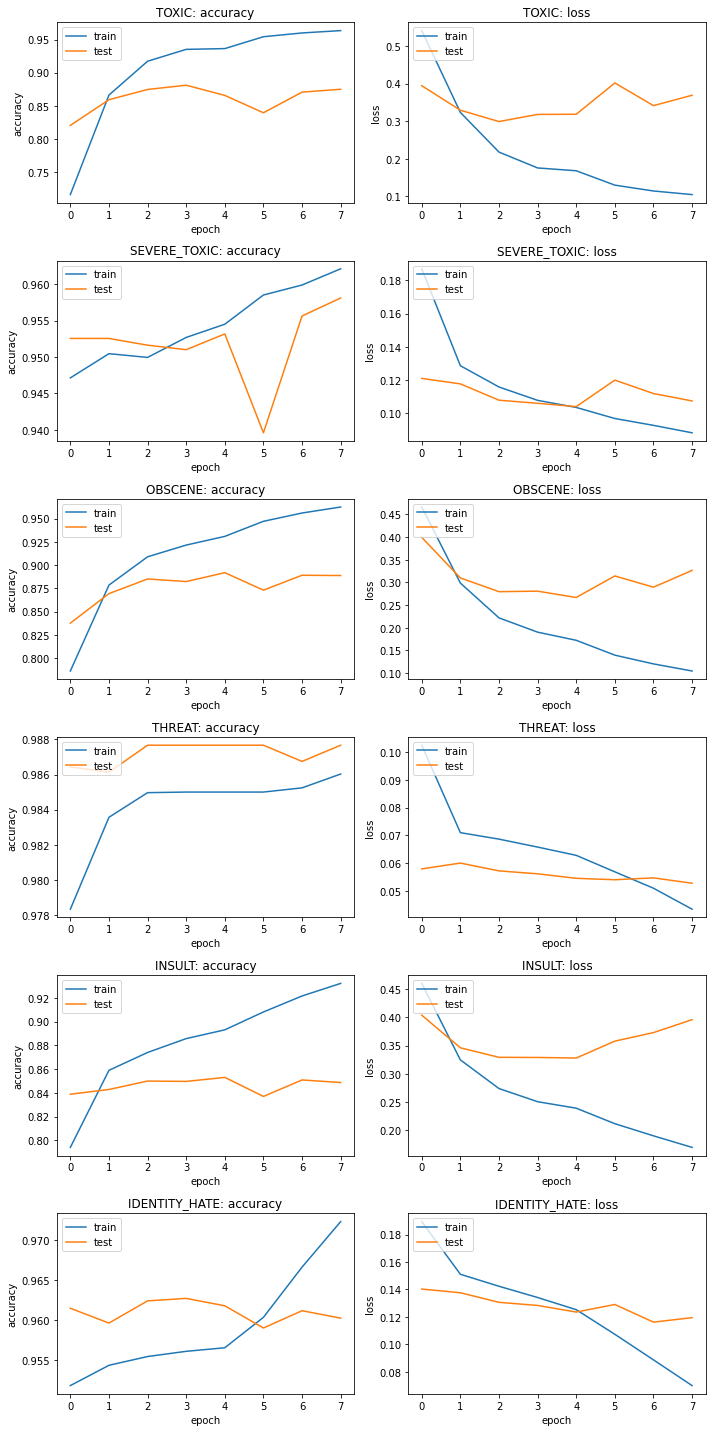

In [ ]:
f, ax = plt.subplots(6, 2, figsize=(10,20))
for i in range(6):
    for j in range(2):
        if j == 0:
            ax[i,j].plot(model_fit.history[f'dense_{i+1}_acc'])
            ax[i,j].plot(model_fit.history[f'val_dense_{i+1}_acc'])
            ax[i,j].set_title(f'{labels[i].upper()}: accuracy')
            ax[i,j].set_ylabel('accuracy')
            ax[i,j].set_xlabel('epoch')
            ax[i,j].legend(['train','test'], loc='upper left')
        else:
            ax[i,j].plot(model_fit.history[f'dense_{i+1}_loss'])
            ax[i,j].plot(model_fit.history[f'val_dense_{i+1}_loss'])
            ax[i,j].set_title(f'{labels[i].upper()}: loss')
            ax[i,j].set_ylabel('loss')
            ax[i,j].set_xlabel('epoch')
            ax[i,j].legend(['train','test'], loc='upper left')

f.tight_layout()

However, since the different labels were still unbalanced, the real focus we had to make was on the other evaluation metrics:

In [ ]:
predictions = newmodel.predict(X_test)
classes = []
i = 0
for pred in predictions:
    classes.append([])
    for pr in pred:
        if pr >= 0.5:
            classes[i].append(1)
        else:
            classes[i].append(0)
    i += 1
    
classes = np.array(classes)
classes = classes.T

In [ ]:
print(classification_report(y_test.values, classes))

              precision    recall  f1-score   support

           0       0.31      0.93      0.47      6081
           1       0.41      0.20      0.27       366
           2       0.51      0.73      0.60      3684
           3       0.00      0.00      0.00       211
           4       0.57      0.62      0.59      3422
           5       0.72      0.06      0.11       712

   micro avg       0.39      0.73      0.51     14476
   macro avg       0.42      0.42      0.34     14476
weighted avg       0.44      0.73      0.50     14476
 samples avg       0.08      0.07      0.07     14476



Looking at the classification report above, it seems that the model improved its performance for the classes of toxicity related to "severe toxic" (1), "threat" (3) and "identity hate" (5) that previously performed very bad, but at the same time worsened in correctly predicting the other classes ("toxic" (0), "obscene" (2) and "insult" (4)). 

In this case the undersampling did not provide the desired improving results. As previously described, one possible solution for improving the model could be  the integration of the already available comments with more labeled comments, trying to increase the number of comments for the different classes of toxicity and, even better, to balance their frequencies.

## 4. BERT APPROACH

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.backend import clear_session
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.metrics import multilabel_confusion_matrix as mcm, classification_report
from keras.backend import clear_session
import warnings
import random
warnings.filterwarnings("ignore")
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
tf.get_logger().setLevel('ERROR')

In [ ]:
complete = pd.read_csv("complete.csv")

We used the same cleaned and complete dataset of the previous model.

In [ ]:
complete.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_com,Word_Counts,Words,text_noStopWords,Words_noStop,others,clean_mystop,words_clean_mystop
0,249153143547788,No need to follow this Policy Taivo instead of...,0,0,0,0,0,0,no need to follow this policy taivo instead of...,73,"['no', 'need', 'to', 'follow', 'this', 'policy...",need follow policy taivo instead following far...,"['need', 'follow', 'policy', 'taivo', 'instead...",1,no need to follow this policy taivo instead of...,"['no', 'need', 'to', 'follow', 'this', 'policy..."
1,370084287833724,"""\n\nIs this person cuchullian a member of the...",0,0,0,0,0,0,is this person cuchullian a member of the klu ...,210,"['is', 'this', 'person', 'cuchullian', 'a', 'm...",person cuchullian member klu klux klan reincar...,"['person', 'cuchullian', 'member', 'klu', 'klu...",1,is this person cuchullian a member of the klu ...,"['is', 'this', 'person', 'cuchullian', 'a', 'm..."
2,463311984751990,"""\n\nWhilst I don't agree with your reasoning,...",0,0,0,0,0,0,whilst i do not agree with your reasoning i am...,302,"['whilst', 'i', 'do', 'not', 'agree', 'with', ...",whilst agree reasoning happy add reference rea...,"['whilst', 'agree', 'reasoning', 'happy', 'add...",1,whilst i do not agree with your reasoning i am...,"['whilst', 'i', 'do', 'not', 'agree', 'with', ..."
3,555281658565433,"December 2008 (UTC)\n\nWell said, I had exactl...",0,0,0,0,0,0,december 2008 utc well said i had exactly the ...,19,"['december', '2008', 'utc', 'well', 'said', 'i...",december 2008 utc said exactly good reason 22 ...,"['december', '2008', 'utc', 'said', 'exactly',...",1,december 2008 utc well said i had exactly the ...,"['december', '2008', 'utc', 'well', 'said', 'i..."
4,677031090441076,"""Awesome, thanks for taking the time to do so,...",0,0,0,0,0,0,awesome thanks for taking the time to do so lo...,41,"['awesome', 'thanks', 'for', 'taking', 'the', ...",awesome thanks taking time look forward runnin...,"['awesome', 'thanks', 'taking', 'time', 'look'...",1,awesome thanks for taking the time to do so lo...,"['awesome', 'thanks', 'for', 'taking', 'the', ..."


### SETTING THE MODEL

`BERT` and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers.

We used a simple BERT model to classify the dataset and to compare the performance with LSTM model.

First of all we divided dataset in train and test and `y_train` and `y_test` have been splitted in 6 variables one for each label.

In [ ]:
X = complete["clean_mystop"].astype(str)
y = complete[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]

X_train = X.iloc[:159571].reset_index(drop=True)
X_test = X.iloc[159571:].reset_index(drop=True)

y_train = y.iloc[:159571].reset_index(drop=True)
y_test = y.iloc[159571:].reset_index(drop=True)

# First output
y1_train = y_train[["toxic"]].values
y1_test =  y_test[["toxic"]].values

# Second output
y2_train = y_train[["severe_toxic"]].values
y2_test =  y_test[["severe_toxic"]].values

# Third output
y3_train = y_train[["obscene"]].values
y3_test =  y_test[["obscene"]].values

# Fourth output
y4_train = y_train[["threat"]].values
y4_test =  y_test[["threat"]].values

# Fifth output
y5_train = y_train[["insult"]].values
y5_test =  y_test[["insult"]].values

# Sixth output
y6_train = y_train[["identity_hate"]].values
y6_test =  y_test[["identity_hate"]].values

The preprocess layer and the encoder layer are directly loaded from Tensorflow Hub.

In [ ]:
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"

As in previous model we interpret the architecture as the combination of 6 binary classification models.
The Bert model is composed by:
- Input layer to load comments;
- Preprocessing layer because the text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT;
- Encoder layer this is the BERT encoder with 4 layers and 512 hidden size (number of hidden nodes for layers)
- 6 outputs, one for each label, in this case we use as activation functions Sigmoid;
- `Adam` as optimization algorithm because is faster than SGD;
- `Binary Cross Entropy` as loss function to classify labels;
- The early stopping allow us to stop training before the end if after 3 epoch, in which the loss doesn't reach its minimum;
- Batch size equal to 256 in way to take in consideration for each batch all labels.

In [ ]:
clear_session()
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)
net = outputs['pooled_output']
output1 = tf.keras.layers.Dense(1, activation='sigmoid', name="dense_1")(net)
output2 = tf.keras.layers.Dense(1, activation='sigmoid', name="dense_2")(net)
output3 = tf.keras.layers.Dense(1, activation='sigmoid', name="dense_3")(net)
output4 = tf.keras.layers.Dense(1, activation='sigmoid', name="dense_4")(net)
output5 = tf.keras.layers.Dense(1, activation='sigmoid', name="dense_5")(net)
output6 = tf.keras.layers.Dense(1, activation='sigmoid', name="dense_6")(net)

model = tf.keras.Model(inputs=text_input, outputs=[output1, output2, output3, output4, output5, output6])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 3, verbose = 1, mode = "auto", restore_best_weights = True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("bert_model.h5", save_best_only=True)

In [ ]:
batch_size = 256
model_fit = model.fit(x=X_train, y=[y1_train, y2_train, y3_train, y4_train, y5_train, y6_train], epochs = 5, 
                      batch_size = batch_size, 
                      callbacks = [early_stopping_callback, checkpoint_cb],validation_split = 0.1,verbose = 1)

Epoch 1/5
561/561 [==============================] - 1688s 3s/step - loss: 0.4527 - dense_1_loss: 0.1689 - dense_2_loss: 0.0324 - dense_3_loss: 0.0890 - dense_4_loss: 0.0184 - dense_5_loss: 0.1048 - dense_6_loss: 0.0391 - dense_1_acc: 0.9420 - dense_2_acc: 0.9891 - dense_3_acc: 0.9684 - dense_4_acc: 0.9955 - dense_5_acc: 0.9609 - dense_6_acc: 0.9894 - val_loss: 0.4214 - val_dense_1_loss: 0.1633 - val_dense_2_loss: 0.0304 - val_dense_3_loss: 0.0849 - val_dense_4_loss: 0.0151 - val_dense_5_loss: 0.0922 - val_dense_6_loss: 0.0356 - val_dense_1_acc: 0.9429 - val_dense_2_acc: 0.9903 - val_dense_3_acc: 0.9722 - val_dense_4_acc: 0.9974 - val_dense_5_acc: 0.9667 - val_dense_6_acc: 0.9913
Epoch 2/5
561/561 [==============================] - 1687s 3s/step - loss: 0.7636 - dense_1_loss: 0.2858 - dense_2_loss: 0.0501 - dense_3_loss: 0.1830 - dense_4_loss: 0.0202 - dense_5_loss: 0.1766 - dense_6_loss: 0.0478 - dense_1_acc: 0.9125 - dense_2_acc: 0.9900 - dense_3_acc: 0.9514 - dense_4_acc: 0.9970 - d

After 4 epochs the training stop.

### TESTING THE MODEL

In [ ]:
batch_size = 256
newmodel = tf.keras.models.load_model("bert_model.h5",custom_objects={'KerasLayer':hub.KerasLayer})
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
score = newmodel.evaluate(x=X_test, y=[y1_test, y2_test, y3_test, y4_test, y5_test, y6_test],batch_size=batch_size, verbose=0)
print(f"test_overal_loss: {score[0]}")
i = 1
for label in labels:
    print(f"{i}) {label:{14}}=> test_loss: {score[i]:.6f}, test_acc: {score[i+6]:.3f}")
    i += 1

test_overal_loss: 0.5200181007385254
1) toxic         => test_loss: 0.185212, test_acc: 0.931
2) severe_toxic  => test_loss: 0.023301, test_acc: 0.994
3) obscene       => test_loss: 0.121930, test_acc: 0.958
4) threat        => test_loss: 0.017828, test_acc: 0.997
5) insult        => test_loss: 0.122982, test_acc: 0.954
6) identity_hate => test_loss: 0.048765, test_acc: 0.989


Results show that for each label we have an accuracy greater than 0.9, But as we said before the dataset is unbalanced, therefore we need to see other misures to show how the BERT model is able to classify each label.

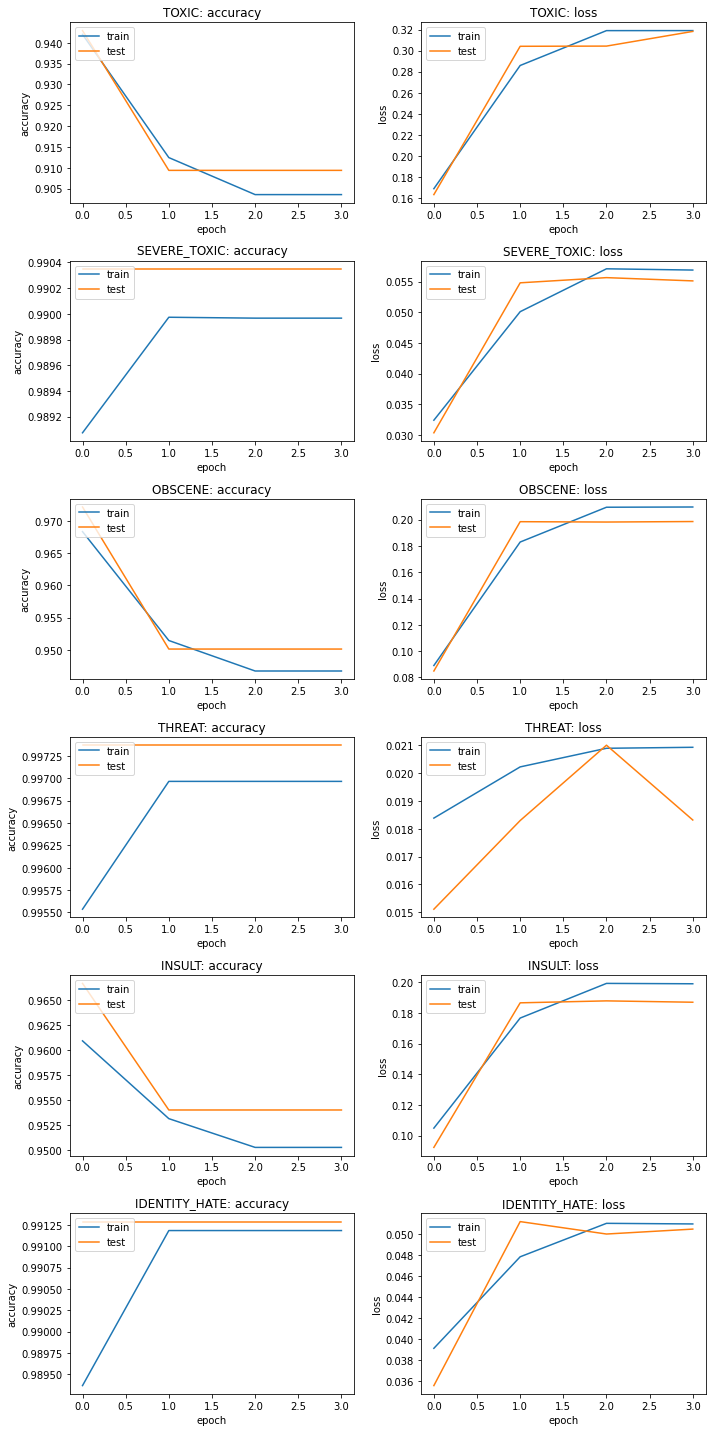

In [ ]:
f, ax = plt.subplots(6, 2, figsize=(10,20))
for i in range(6):
    for j in range(2):
        if j == 0:
            ax[i,j].plot(model_fit.history[f'dense_{i+1}_acc'])
            ax[i,j].plot(model_fit.history[f'val_dense_{i+1}_acc'])
            ax[i,j].set_title(f'{labels[i].upper()}: accuracy')
            ax[i,j].set_ylabel('accuracy')
            ax[i,j].set_xlabel('epoch')
            ax[i,j].legend(['train','test'], loc='upper left')
        else:
            ax[i,j].plot(model_fit.history[f'dense_{i+1}_loss'])
            ax[i,j].plot(model_fit.history[f'val_dense_{i+1}_loss'])
            ax[i,j].set_title(f'{labels[i].upper()}: loss')
            ax[i,j].set_ylabel('loss')
            ax[i,j].set_xlabel('epoch')
            ax[i,j].legend(['train','test'], loc='upper left')

f.tight_layout()   

The charts explain we reach the minimum loss and the higer accuracy level on first epoch (loss equal to 0.4214). After this point, the trends of loss charts became either stable or decreasing.

In [ ]:
predictions = newmodel.predict(X_test)
classes = []
i = 0
for pred in predictions:
    classes.append([])
    for pr in pred:
        if pr >= 0.5:
            classes[i].append(1)
        else:
            classes[i].append(0)
    i += 1
    
classes = np.array(classes)
classes = classes.T

In [ ]:
print(classification_report(y_test, classes))

              precision    recall  f1-score   support

           0       0.75      0.42      0.53      6081
           1       0.00      0.00      0.00       366
           2       0.74      0.43      0.54      3684
           3       0.00      0.00      0.00       211
           4       0.62      0.37      0.47      3422
           5       0.00      0.00      0.00       712

   micro avg       0.71      0.37      0.49     14476
   macro avg       0.35      0.20      0.26     14476
weighted avg       0.65      0.37      0.47     14476
 samples avg       0.04      0.03      0.03     14476



The classification report function detects the model is not able to classify 3 labels: `severe_toxic`, `threat`, `identity_hate`. the other targets have not a good `f1-score` (values around 0.5).

### UNDERSAMPLING

#### **Setting the dataset**

In order to improve the detection and prediction ability of BERT model, also in this case we applied an `undersampling` in way to reduce the number of un-labeled observations and increasing the balance of train dataset.

The following functions was created in way to make the undersampling.

In [ ]:
def sample_together(n, X, y):
    rows = random.sample(np.arange(0,len(X.index)).tolist(),n)
    return X.iloc[rows,], y.iloc[rows,]

In [ ]:
def undersample(X, y, under = 0):
    y_min = y[complete.others == under]
    y_max = y[complete.others != under]
    X_min = X.filter(y_min.index,axis = 0)
    X_max = X.filter(y_max.index,axis = 0)

    X_under, y_under = sample_together(len(y_min.index), X_max, y_max)
    
    X = pd.concat([X_under, X_min]).sample(32450,random_state=200).reset_index(drop=True)
    y = pd.concat([y_under, y_min]).sample(32450,random_state=200).reset_index(drop=True)
    return X, y

X_train, y_train = undersample(X_train, y_train)

In [ ]:
X_train.shape, y_train.shape

((32450,), (32450, 6))

From over 160 thousand of observation, we have around 30 thousand of observations

Then we applied the same functions and classes as before to refine tune the BERT model

In [ ]:
X_train

0        masturbation graemel i was wondering if your e...
1        rob you are a little coward and thuggish boor ...
2        ok thanks for deleting and for the tip on the ...
3        the israelis are committing massacres in gaza ...
4        pmk your opinion about ethnical belonging of m...
                               ...                        
32445    sup dude i am not spamming fuck you learn to r...
32446    listen stupid wiki is basically stealing my st...
32447    primary topic is for two different types of to...
32448    response i think the issue of whether someone ...
32449    but what neither brews nor yourself have been ...
Name: clean_mystop, Length: 32450, dtype: object

In [ ]:
y_train

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,1,0,0,0,1,0
1,1,0,1,0,1,0
2,0,0,0,0,0,0
3,0,0,0,0,0,1
4,0,0,0,0,0,0
...,...,...,...,...,...,...
32445,1,0,1,0,1,0
32446,1,0,1,0,0,0
32447,0,0,0,0,0,0
32448,0,0,0,0,0,0


In [ ]:
# First output
y1_train = y_train[["toxic"]].values

# Second output
y2_train = y_train[["severe_toxic"]].values

# Third output
y3_train = y_train[["obscene"]].values

# Fourth output
y4_train = y_train[["threat"]].values

# Fifth output
y5_train = y_train[["insult"]].values

# Sixth output
y6_train = y_train[["identity_hate"]].values

#### **Setting the model**

In [ ]:
clear_session()
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)
net = outputs['pooled_output']
output1 = tf.keras.layers.Dense(1, activation='sigmoid', name="dense_1")(net)
output2 = tf.keras.layers.Dense(1, activation='sigmoid', name="dense_2")(net)
output3 = tf.keras.layers.Dense(1, activation='sigmoid', name="dense_3")(net)
output4 = tf.keras.layers.Dense(1, activation='sigmoid', name="dense_4")(net)
output5 = tf.keras.layers.Dense(1, activation='sigmoid', name="dense_5")(net)
output6 = tf.keras.layers.Dense(1, activation='sigmoid', name="dense_6")(net)

model = tf.keras.Model(inputs=text_input, outputs=[output1, output2, output3, output4, output5, output6])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 3, verbose = 1, mode = "auto", restore_best_weights = True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("bert_model_undersample.h5", save_best_only=True)

In [ ]:
batch_size = 256
model_fit = model.fit(x=X_train, y=[y1_train, y2_train, y3_train, y4_train, y5_train, y6_train], epochs = 5, 
                      batch_size = batch_size, 
                      callbacks = [early_stopping_callback, checkpoint_cb],validation_split = 0.1,verbose = 1)

Epoch 1/5
115/115 [==============================] - 353s 3s/step - loss: 1.4101 - dense_1_loss: 0.3608 - dense_2_loss: 0.1479 - dense_3_loss: 0.2921 - dense_4_loss: 0.0825 - dense_5_loss: 0.3602 - dense_6_loss: 0.1667 - dense_1_acc: 0.8370 - dense_2_acc: 0.9468 - dense_3_acc: 0.8717 - dense_4_acc: 0.9765 - dense_5_acc: 0.8239 - dense_6_acc: 0.9483 - val_loss: 1.3012 - val_dense_1_loss: 0.3471 - val_dense_2_loss: 0.1110 - val_dense_3_loss: 0.2900 - val_dense_4_loss: 0.0600 - val_dense_5_loss: 0.3562 - val_dense_6_loss: 0.1370 - val_dense_1_acc: 0.8441 - val_dense_2_acc: 0.9529 - val_dense_3_acc: 0.8604 - val_dense_4_acc: 0.9877 - val_dense_5_acc: 0.8145 - val_dense_6_acc: 0.9624
Epoch 2/5
115/115 [==============================] - 347s 3s/step - loss: 1.0478 - dense_1_loss: 0.2266 - dense_2_loss: 0.1134 - dense_3_loss: 0.2119 - dense_4_loss: 0.0694 - dense_5_loss: 0.2811 - dense_6_loss: 0.1454 - dense_1_acc: 0.9111 - dense_2_acc: 0.9503 - dense_3_acc: 0.9118 - dense_4_acc: 0.9850 - den

#### **Testing the model**

In [ ]:
batch_size = 256
newmodel = tf.keras.models.load_model("bert_model_undersample.h5",custom_objects={'KerasLayer':hub.KerasLayer})
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
score = newmodel.evaluate(x=X_test, y=[y1_test, y2_test, y3_test, y4_test, y5_test, y6_test],batch_size=batch_size, verbose=0)
print(f"test_overal_loss: {score[0]}")
i = 1
for label in labels:
    print(f"{i}) {label:{14}}=> test_loss: {score[i]:.6f}, test_acc: {score[i+6]:.3f}")
    i += 1

test_overal_loss: 0.6926455497741699
1) toxic         => test_loss: 0.399468, test_acc: 0.813
2) severe_toxic  => test_loss: 0.018934, test_acc: 0.993
3) obscene       => test_loss: 0.096644, test_acc: 0.965
4) threat        => test_loss: 0.019434, test_acc: 0.997
5) insult        => test_loss: 0.115510, test_acc: 0.957
6) identity_hate => test_loss: 0.042655, test_acc: 0.989


Also in this case model detect an high level of accuracy for each label. So we need to analyze in detail the outcomes seeing the f1-score, the better metric for unbalanced dataset.

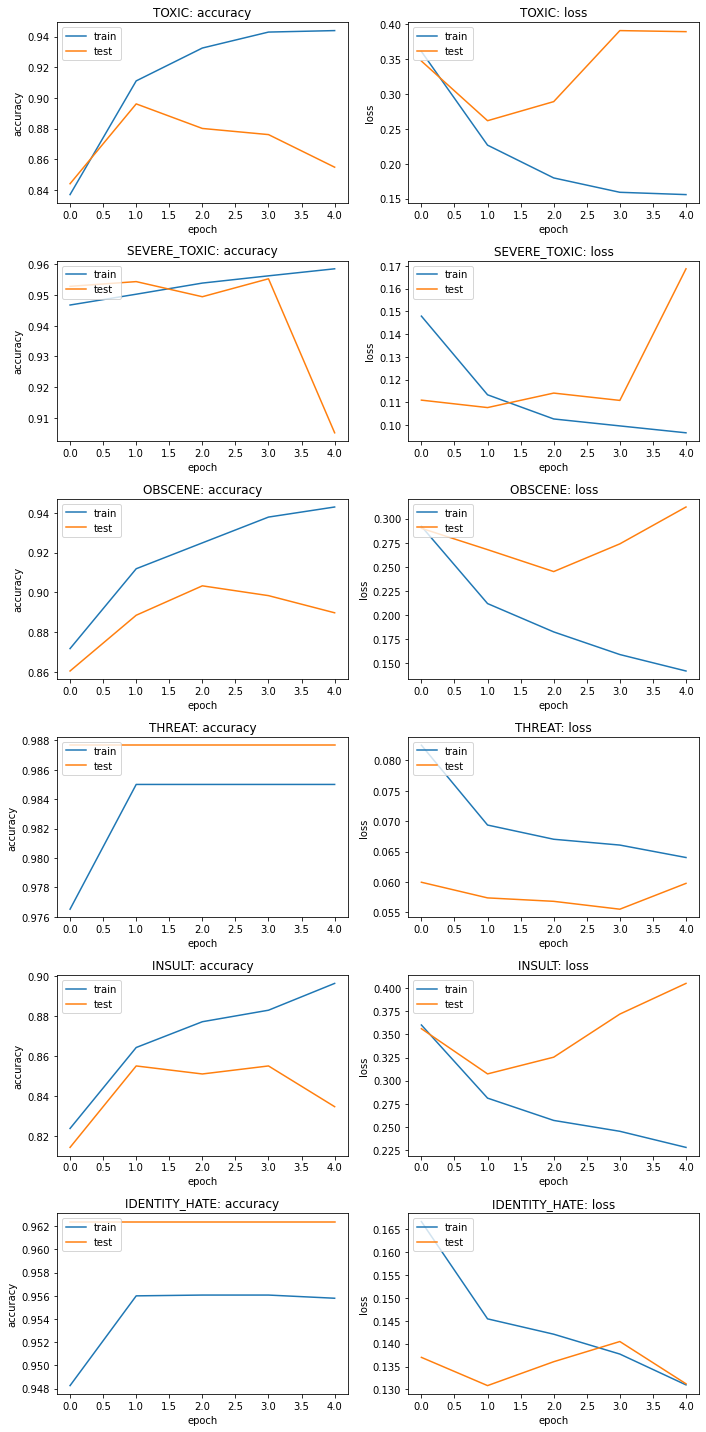

In [ ]:
f, ax = plt.subplots(6, 2, figsize=(10,20))
for i in range(6):
    for j in range(2):
        if j == 0:
            ax[i,j].plot(model_fit.history[f'dense_{i+1}_acc'])
            ax[i,j].plot(model_fit.history[f'val_dense_{i+1}_acc'])
            ax[i,j].set_title(f'{labels[i].upper()}: accuracy')
            ax[i,j].set_ylabel('accuracy')
            ax[i,j].set_xlabel('epoch')
            ax[i,j].legend(['train','test'], loc='upper left')
        else:
            ax[i,j].plot(model_fit.history[f'dense_{i+1}_loss'])
            ax[i,j].plot(model_fit.history[f'val_dense_{i+1}_loss'])
            ax[i,j].set_title(f'{labels[i].upper()}: loss')
            ax[i,j].set_ylabel('loss')
            ax[i,j].set_xlabel('epoch')
            ax[i,j].legend(['train','test'], loc='upper left')

f.tight_layout()   

The charts explain we reach the minimum loss and the higer accuracy level on second epoch (loss equal to 1.1327, greater respect to the train dataset before the undersampling). After this point, the trend for loss charts became either stable or decreasing.

In [ ]:
predictions = newmodel.predict(X_test)
classes = []
i = 0
for pred in predictions:
    classes.append([])
    for pr in pred:
        if pr >= 0.5:
            classes[i].append(1)
        else:
            classes[i].append(0)
    i += 1
    
classes = np.array(classes)
classes = classes.T

In [ ]:
print(classification_report(y_test, classes))

              precision    recall  f1-score   support

           0       0.30      0.96      0.46      6081
           1       0.32      0.41      0.36       366
           2       0.69      0.66      0.68      3684
           3       0.00      0.00      0.00       211
           4       0.53      0.66      0.59      3422
           5       0.00      0.00      0.00       712

   micro avg       0.39      0.74      0.51     14476
   macro avg       0.31      0.45      0.35     14476
weighted avg       0.44      0.74      0.51     14476
 samples avg       0.08      0.07      0.07     14476



In this case, respect to trained BERT model before the undersampling, we can be able also to classify the `severe_toxic` label. The metrics show that the performance of this model is low also after the balance of train dataset.

### CONCLUSION

If we compare `LSTM` model and `BERT` model the results from both show a low performance to classify the toxicity of dataset.

The first one detect better performance before apply the undersampling, in the second one there is the opposite situation. Comparing both models the outputs show LSTM as better than BERT even because is able to classify more labels. Furthermore the first require less time to be fine-tuned.

In a situation of imbalanced labels as this one, the deep learning classifier tends to be more biased towards the majority class (un-labaled), causing bad classification of the minority class (labeled). 

Since the imbalanced distribution of the target variables, It's difficult implement models able to well predict the results. A possible solution can be create a more complex architecture, but it require an high level of memory and performance that the platforms used to make this analysis do not let us to use. 
